In [ ]:
import os
import pandas as pd
import numpy as np
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import itertools
from prettytable import PrettyTable
from matplotlib.colors import ListedColormap

In [ ]:
path_avaliacao = "/content/drive/MyDrive/Colab Notebooks/avaliacao/"

path_results_notebook_3p = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/nCopResultsNotebookFrequence/3p/'
path_results_notebook_5p = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/nCopResultsNotebookFrequence/5p/'
path_results_notebook_10p = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/nCopResultsNotebookFrequence/10p/'

path_results_cluster_3p = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/nCopResultsClusterFrequence/3p/'
path_results_cluster_5p = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/nCopResultsClusterFrequence/5p/'
path_results_cluster_10p = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/nCopResultsClusterFrequence/10p/'

path_intogen = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/Intogen/'
path_cancermine = '/content/drive/MyDrive/Colab Notebooks/cancermine/'

path_mafs_list = '/content/drive/MyDrive/Colab Notebooks/enriquecimento/Endeavour/MAF_lists/'

In [ ]:
cancer_type_3p_paper = ['BLCA', 'BRCA', 'GBM', 'PAAD', 'PRAD', 'STAD']
cancer_type_5p_paper = ['BLCA', 'BRCA', 'GBM', 'PAAD', 'PRAD', 'STAD']
cancer_type_10p_paper = ['BLCA', 'BRCA', 'GBM', 'PAAD', 'PRAD', 'STAD']

cancer_type_3p = ['ACC', 'BLCA', 'BRCA', 'CESC', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'OV', 'PAAD', 'PCPG', 'PRAD', 'SKCM', 'STAD', 'THCA', 'UCEC', 'UCS']
cancer_type_5p = ['ACC', 'BLCA', 'BRCA', 'CESC', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'OV', 'PAAD', 'PCPG', 'PRAD', 'SKCM', 'STAD', 'THCA', 'UCEC', 'UCS']
cancer_type_10p = ['ACC', 'BLCA', 'BRCA', 'CESC', 'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'THCA', 'UCEC', 'UCS']

In [ ]:
"""
Gera uma lista com o nome de todos os arquivos do diretório (mafs ou redes)
"""
def file_list_in_dir(path):
    l_files = []
    for _, _, file in os.walk(path):
        l_files = file
    return l_files

def file_list_in_dir_tpcan(path, tpcan):
    l_files = []
    for _, _, file in os.walk(path):
        for i in file:
            if tpcan in i.upper():
                l_files.append(i)
    return l_files



# Benchmark Analysis

In [ ]:
'''
Analisys via bechmarks
'''
def get_benchmark_genes():
    ncg_file_name = path_avaliacao+"NCG6_tsgoncogene.tsv"
    #cosmic_file_name = path_avaliacao+"CGC_COSMIC_Census_allMon Apr 15 17_32_47 2019.tsv"
    cosmic_file_name = path_avaliacao+'CGC_COSMIC_Census_allTue Jul 27 01_37_31 2021.tsv'

    ncg_df = pd.read_csv(ncg_file_name, sep='\t', usecols=["symbol"])
    cosmic_df = pd.read_csv(cosmic_file_name, sep='\t', usecols=["Gene Symbol"])

    ncg_genes = list(ncg_df["symbol"])
    cosmic_genes = list(cosmic_df["Gene Symbol"])

    benchmark_driver_genes = set(ncg_genes) | set(cosmic_genes)
    
    ncg_file_name = path_avaliacao+"false_positives_NCG6.txt"
    ncg_fp_df = pd.read_csv(ncg_file_name, sep='\t', usecols=["symbol"])
    benchmark_passenger_genes = list(ncg_fp_df["symbol"])
        
#     print("Number of genes in benchmark of drivers: {}".format(len(benchmark_driver_genes)))
#     print("Number of genes in benchmark of passengers: {}".format(len(benchmark_passenger_genes)))
    return benchmark_driver_genes, benchmark_passenger_genes

def get_gene_list(results_file_name, sep=' '):
    results_df = pd.read_csv(results_file_name, sep=sep, usecols=[0], names=["gene"])
    genes_result = list(results_df["gene"])
    return genes_result

def get_sample_percent_intogen(results_file_name, list_genes):
    results_df = pd.read_csv(results_file_name, sep = '\t', usecols=[0, 2], names=["gene", "samples"])
    results_df_filtered = results_df.loc[results_df['gene'].isin(list_genes)]
    samples_percent_result = list(results_df_filtered["samples"])

    return samples_percent_result

def get_sample_percent_intogen_df(results_file_name, list_genes):
    results_df = pd.read_csv(results_file_name, sep = '\t', usecols=[0, 3], names=["gene", "samples"])
    results_df_filtered = results_df.loc[results_df['gene'].isin(list_genes)]
    results_df_filtered['samples'] = results_df_filtered['samples'].str.rstrip('%')
    results_df_filtered['samples'] = results_df_filtered['samples'].astype('float')

    df_results = results_df_filtered.sort_values(['samples'])

    return results_df_filtered


def benchmark_analysis(genes_result, benchmark_driver_genes, benchmark_passenger_genes, N):
    into_driver_benchmark = []
    out_driver_benchmark = []
    into_passenger_benchmark = []
    genes_result = genes_result[0:N]

    for gene in genes_result:
        if gene in benchmark_driver_genes:
            into_driver_benchmark.append(gene)
        else:
            out_driver_benchmark.append(gene)
            if gene in benchmark_passenger_genes:
                into_passenger_benchmark.append(gene)
                
    
    precision = len(into_driver_benchmark) / (len(into_driver_benchmark) + len(out_driver_benchmark))
    false_positive_rate = len(into_passenger_benchmark) / (len(into_driver_benchmark) + len(out_driver_benchmark))
    #print(into_benchmark)
    #print(out_benchmark)
    return precision, false_positive_rate

In [ ]:
def generate_graphs_precision(all_result_files, benchmark_driver_genes, benchmark_passenger_genes, N):
    number_of_columns = 4
    number_of_rows = math.ceil(len(all_result_files)/number_of_columns)
    fig = plt.figure(figsize=(10*number_of_columns, 5*number_of_rows))
    position = 1
    for cancer_type in all_result_files:
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        tab = PrettyTable()
        tab.field_names = ["Cancer", "Resultado", "Media das precisoes", "Media false positive"]
        for result_file_name in all_result_files[cancer_type]:
            gene_results = get_gene_list(result_file_name)
            precision_list = []
            false_positive_list = []
            top_N_list = []
            for i in range(3, N + 1):
                precision, false_positive = benchmark_analysis(gene_results, benchmark_driver_genes, benchmark_passenger_genes, i)
                precision_list.append(precision)
                false_positive_list.append(false_positive)
                top_N_list.append(i)
            #ax.plot(top_N_list, precision_list, '-', label=str(result_file_name[len(result_file_name) - 30:])
            if result_file_name.split("_")[4].upper() == 'ENRIC':
                v_label = "Enriched"
                ax.plot(top_N_list, precision_list, '-', label=v_label, linewidth=3.0, color="blue")
                v_label = "False positive"
                ax.plot(top_N_list, false_positive_list, '-', label=v_label, linewidth=2.0, linestyle = 'dashed', color="blue")
            else:
                v_label = "Normal"
                ax.plot(top_N_list, precision_list, '-', label=v_label, linewidth=3.0, color="green")
                v_label = "False positive"
                ax.plot(top_N_list, false_positive_list, '-', label=v_label, linewidth=2.0, linestyle = 'dashed', color="green")

            #ax.plot(top_N_list, precision_list, '-', label=v_label, linewidth=2.0)
            tab.add_row([cancer_type, v_label, sum(precision_list)/len(precision_list), sum(false_positive_list)/len(false_positive_list)])
            
        #print(tab)
        #print("------")
        ax.legend()
        ax.set_title(cancer_type)
        #print (cancer_type)
        #ax.set_title(cancer_type.split("_")[3])
        ax.set_xlabel('Top N')
        ax.set_ylabel('Precision')
        ax.set_ylim(0.0, 1.1)
        position = position + 1
        plt.grid(True)
    plt.show()

In [ ]:
def generate_graphs_precision_all(all_result_files, benchmark_driver_genes, benchmark_passenger_genes, N, number_of_columns=4):
#    number_of_columns = 4
    number_of_rows = math.ceil(len(all_result_files)/number_of_columns)
    fig = plt.figure(figsize=(10*number_of_columns, 5*number_of_rows))
    position = 1
    for cancer_type in all_result_files:
        """
        Inserido por Alfredo 05/11/2021
        """
        if cancer_type == 'GBM':
            N = 15
        if cancer_type == 'PAAD':
            N = 25
        if cancer_type == 'BLCA':
            N = 60

        ax = plt.subplot(number_of_rows, number_of_columns, position)
        tab = PrettyTable()
        tab.field_names = ["Cancer", "Resultado", "Media das precisoes", "Media false positive"]
        for result_file_name in all_result_files[cancer_type]:
            gene_results = get_gene_list(result_file_name)
            precision_list = []
            false_positive_list = []
            top_N_list = []
            for i in range(3, N + 1):
                precision, false_positive = benchmark_analysis(gene_results, benchmark_driver_genes, benchmark_passenger_genes, i)
                precision_list.append(precision)
                false_positive_list.append(false_positive)
                top_N_list.append(i)
            #ax.plot(top_N_list, precision_list, '-', label=str(result_file_name[len(result_file_name) - 30:])
            if result_file_name.split("_")[4].upper() == 'ENRIC':
                v_label = '>= ' + str(result_file_name.split("_")[3]).replace("p", "%") + " Enriched"
                ax.plot(top_N_list, precision_list, '-', label=v_label, linewidth=3.0)
                #v_label = "False positive"
                #ax.plot(top_N_list, false_positive_list, '-', label=v_label, linewidth=2.0, linestyle = 'dashed', color="blue")
            else:
                v_label = "Normal"
                ax.plot(top_N_list, precision_list, '-', label=v_label, linewidth=3.0, color="black")
                #v_label = "False positive"
                #ax.plot(top_N_list, false_positive_list, '-', label=v_label, linewidth=2.0, linestyle = 'dashed', color="green")
            plt.subplots_adjust(hspace = .4)
            #ax.plot(top_N_list, precision_list, '-', label=v_label, linewidth=2.0)
            tab.add_row([cancer_type, v_label, sum(precision_list)/len(precision_list), sum(false_positive_list)/len(false_positive_list)])
            
        #print(tab)
        #print("------")
        ax.legend()
        ax.set_title(cancer_type)
        #print (cancer_type)
        #ax.set_title(cancer_type.split("_")[3])
        ax.set_xlabel('Top N')
        ax.set_ylabel('Precision')
        ax.set_ylim(0.0, 1.1)
        position = position + 1
        plt.grid(True)
    plt.show()

In [ ]:
def generate_graph(path_results, cancer_type):

    N = 100
    benchmark_driver_genes, benchmark_passenger_genes = get_benchmark_genes()

    all_result_files = {}
    for can in cancer_type:
        l_results = file_list_in_dir_tpcan(path_results, can)
        all_results_cancer_type = []
        all_results_cancer_type.append(path_results+sorted(l_results)[0])
        all_results_cancer_type.append(path_results+sorted(l_results)[1])
        all_result_files[can.upper()] = all_results_cancer_type
        
    generate_graphs_precision(all_result_files, benchmark_driver_genes, benchmark_passenger_genes, N)


In [ ]:
def generate_graph(path_results, cancer_type):

    N = 100
    benchmark_driver_genes, benchmark_passenger_genes = get_benchmark_genes()
    
    all_results_files = {}
    for can in cancer_type:
        l_results = file_list_in_dir_tpcan(path_results, can)
        all_results_cancer_type = []
        all_results_cancer_type.append(path_results+sorted(l_results)[0])
        all_results_cancer_type.append(path_results+sorted(l_results)[1])
        all_results_files[can.upper()] = all_results_cancer_type

    generate_graphs_precision(all_results_files, benchmark_driver_genes, benchmark_passenger_genes, N)



In [ ]:
def generate_graph_all(path_results_notebook_3p, path_results_notebook_5p, path_results_notebook_10p, cancer_type, number_of_columns=4):

    N = 100
    benchmark_driver_genes, benchmark_passenger_genes = get_benchmark_genes()

    all_result_files = {}
    for can in cancer_type:
        l_results_3p = file_list_in_dir_tpcan(path_results_notebook_3p, can)
        l_results_5p = file_list_in_dir_tpcan(path_results_notebook_5p, can)
        l_results_10p = file_list_in_dir_tpcan(path_results_notebook_10p, can)
        all_results_cancer_type = []
        # 3p
        all_results_cancer_type.append(path_results_notebook_3p+sorted(l_results_3p)[1]) # normal
        all_results_cancer_type.append(path_results_notebook_3p+sorted(l_results_3p)[0]) # enric
        # 5p
        all_results_cancer_type.append(path_results_notebook_5p+sorted(l_results_5p)[0]) # enric
        # 10p
        all_results_cancer_type.append(path_results_notebook_10p+sorted(l_results_10p)[0]) # enric

        #print(sorted(l_results_3p)[1]+'\n'+sorted(l_results_3p)[0]+'\n'+sorted(l_results_5p)[0]+'\n'+sorted(l_results_10p)[0])

        all_result_files[can.upper()] = all_results_cancer_type
        
    generate_graphs_precision_all(all_result_files, benchmark_driver_genes, benchmark_passenger_genes, N, number_of_columns)

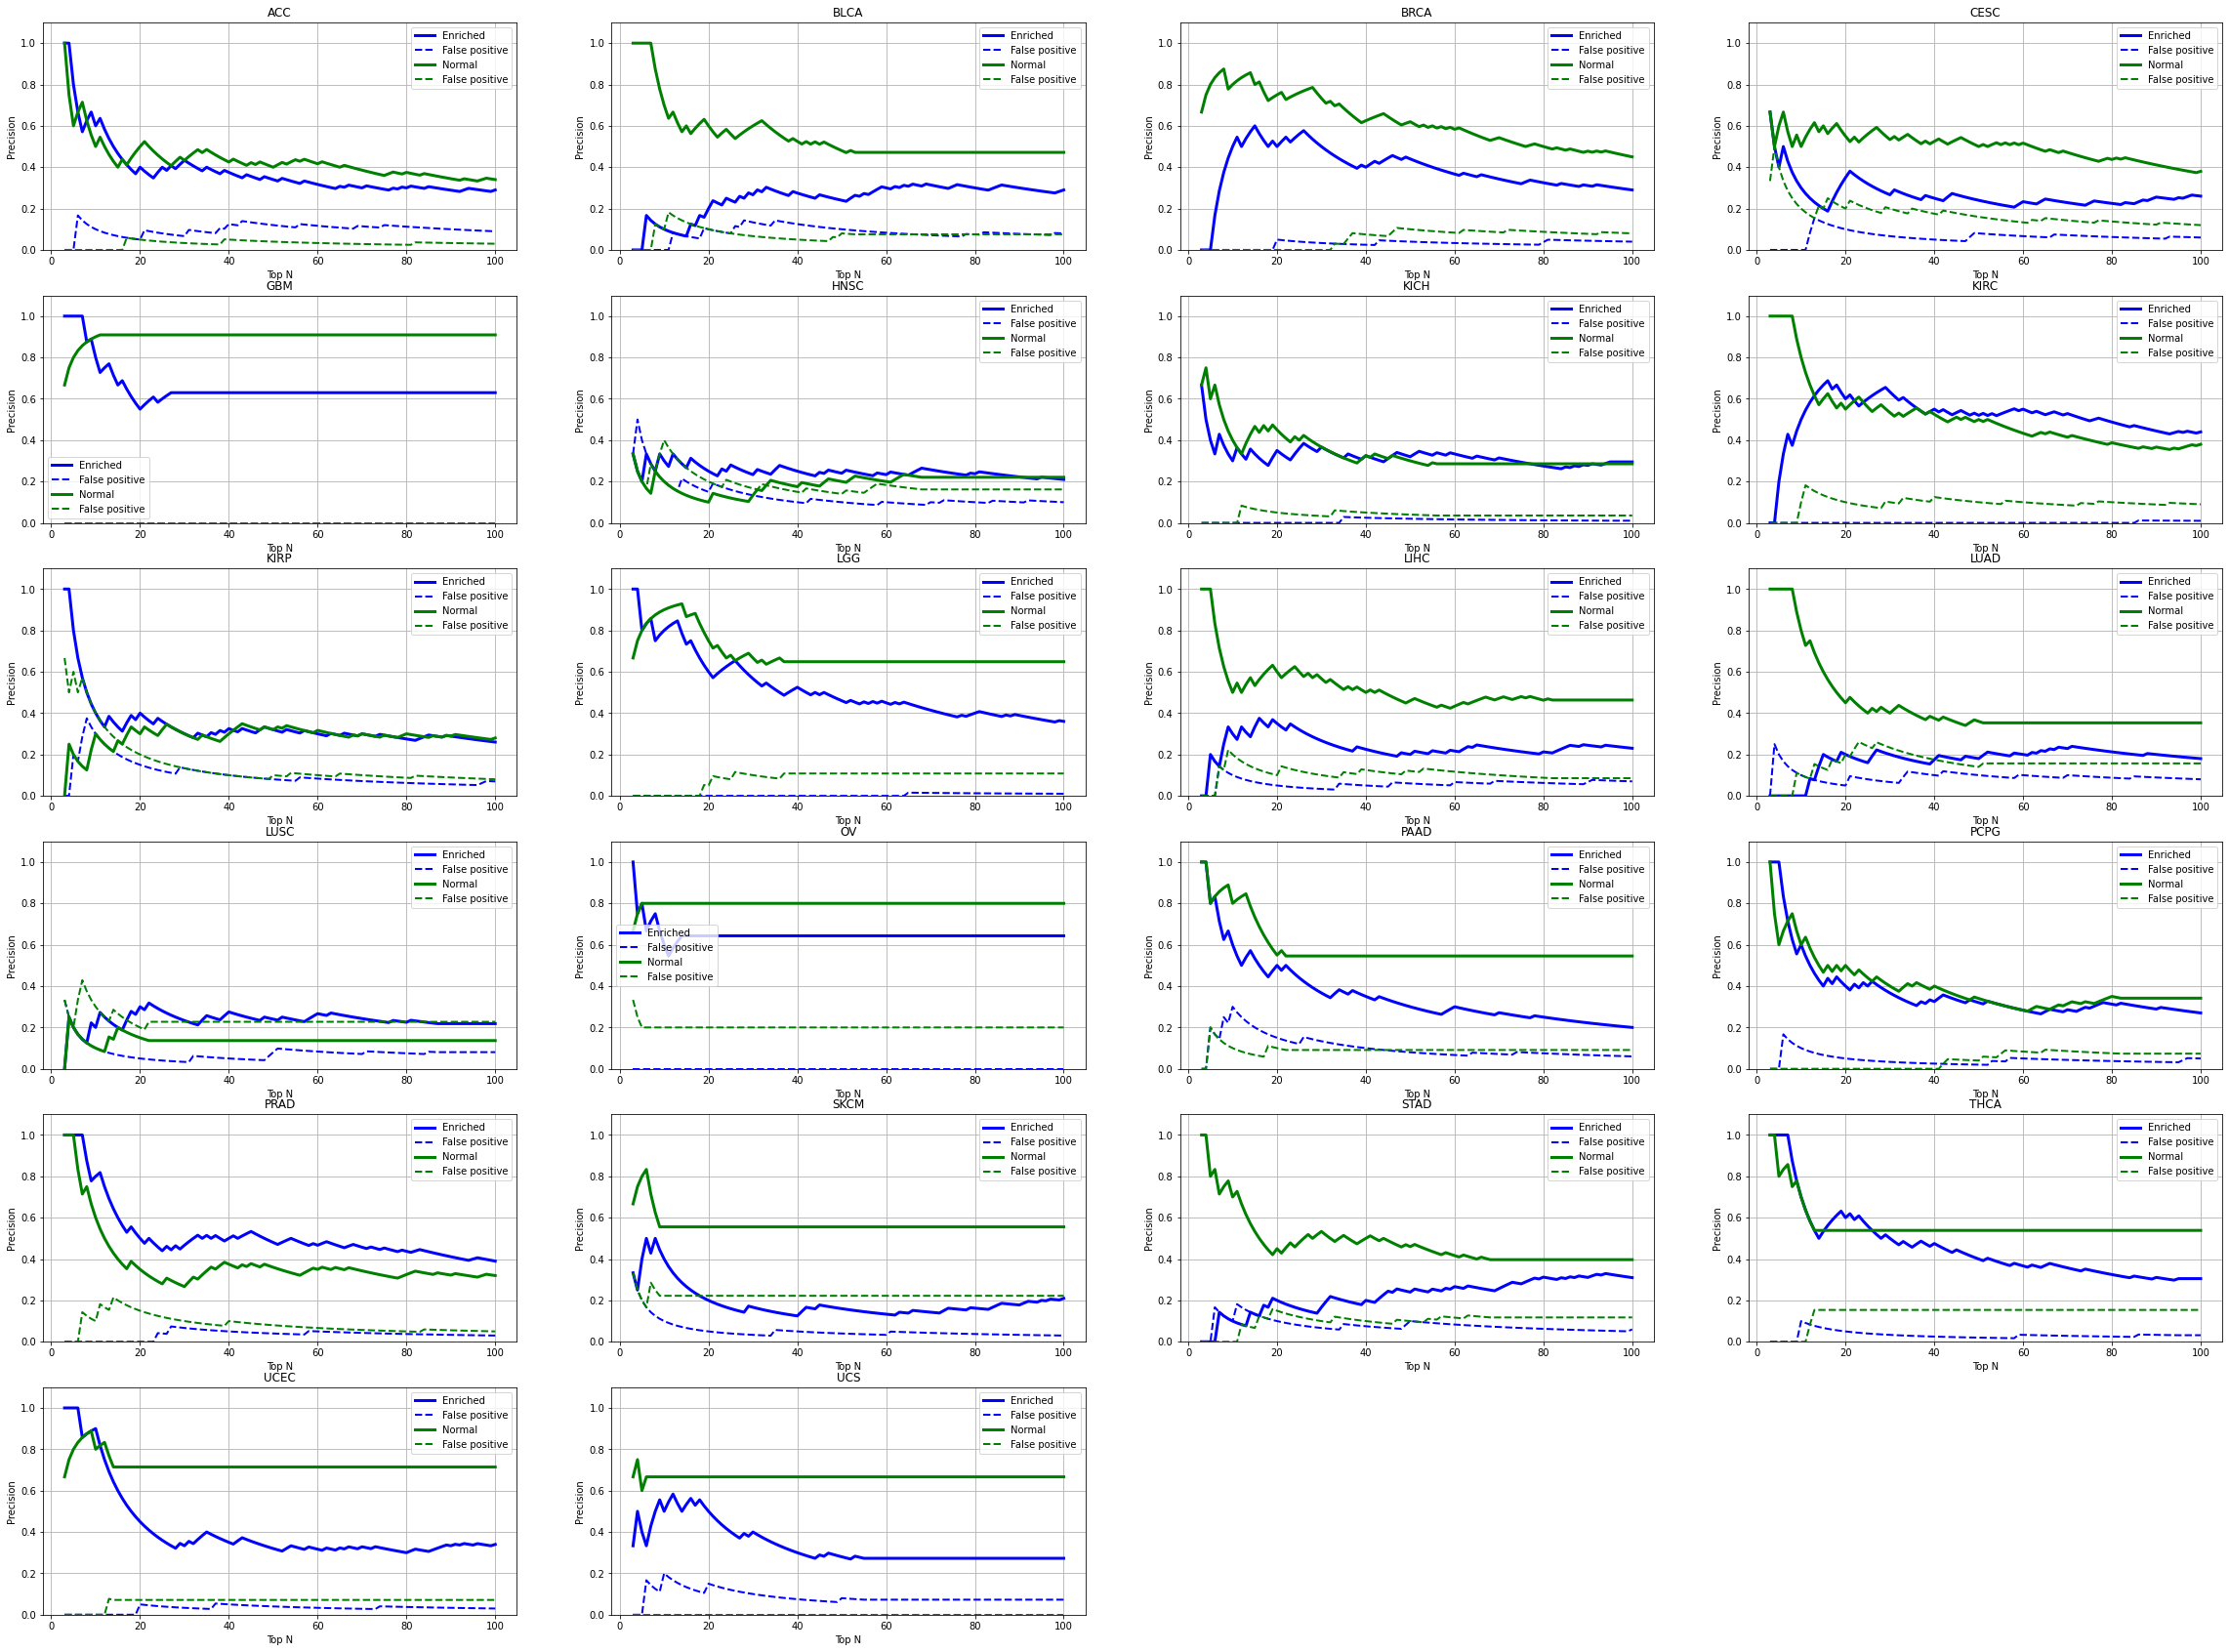

In [ ]:
generate_graph(path_results_notebook_3p, cancer_type_3p)

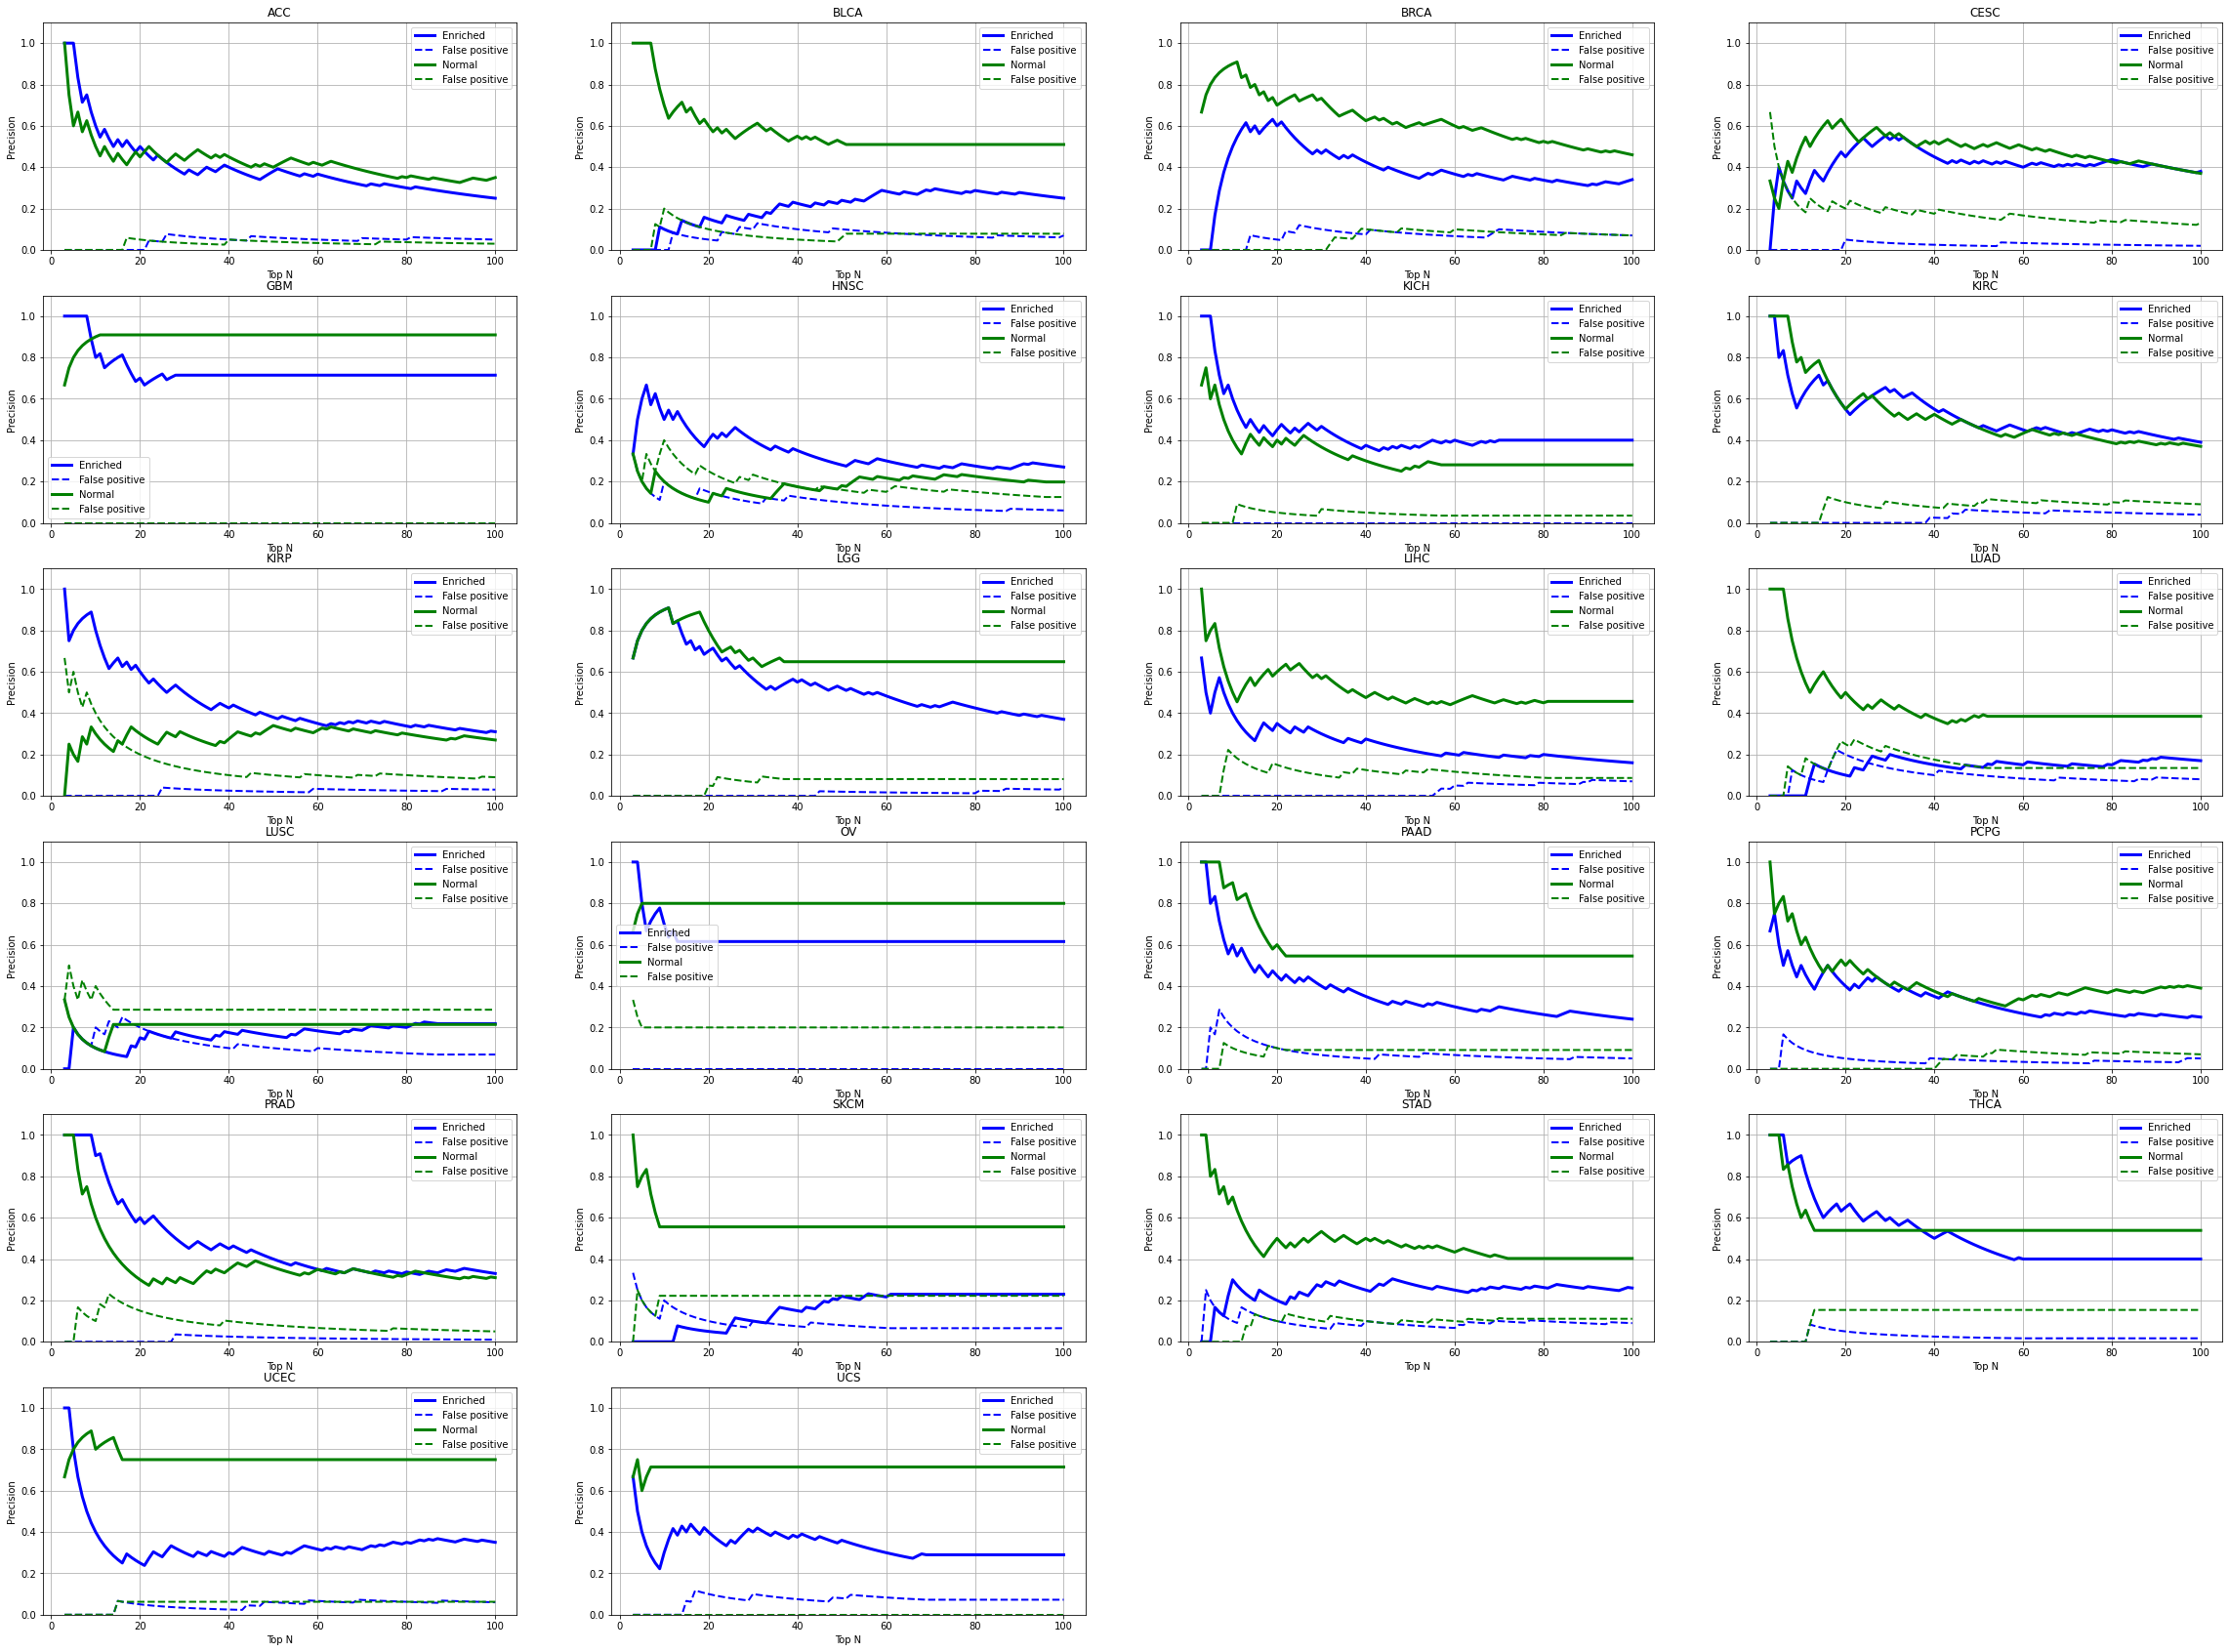

In [ ]:
generate_graph(path_results_notebook_5p, cancer_type_5p)

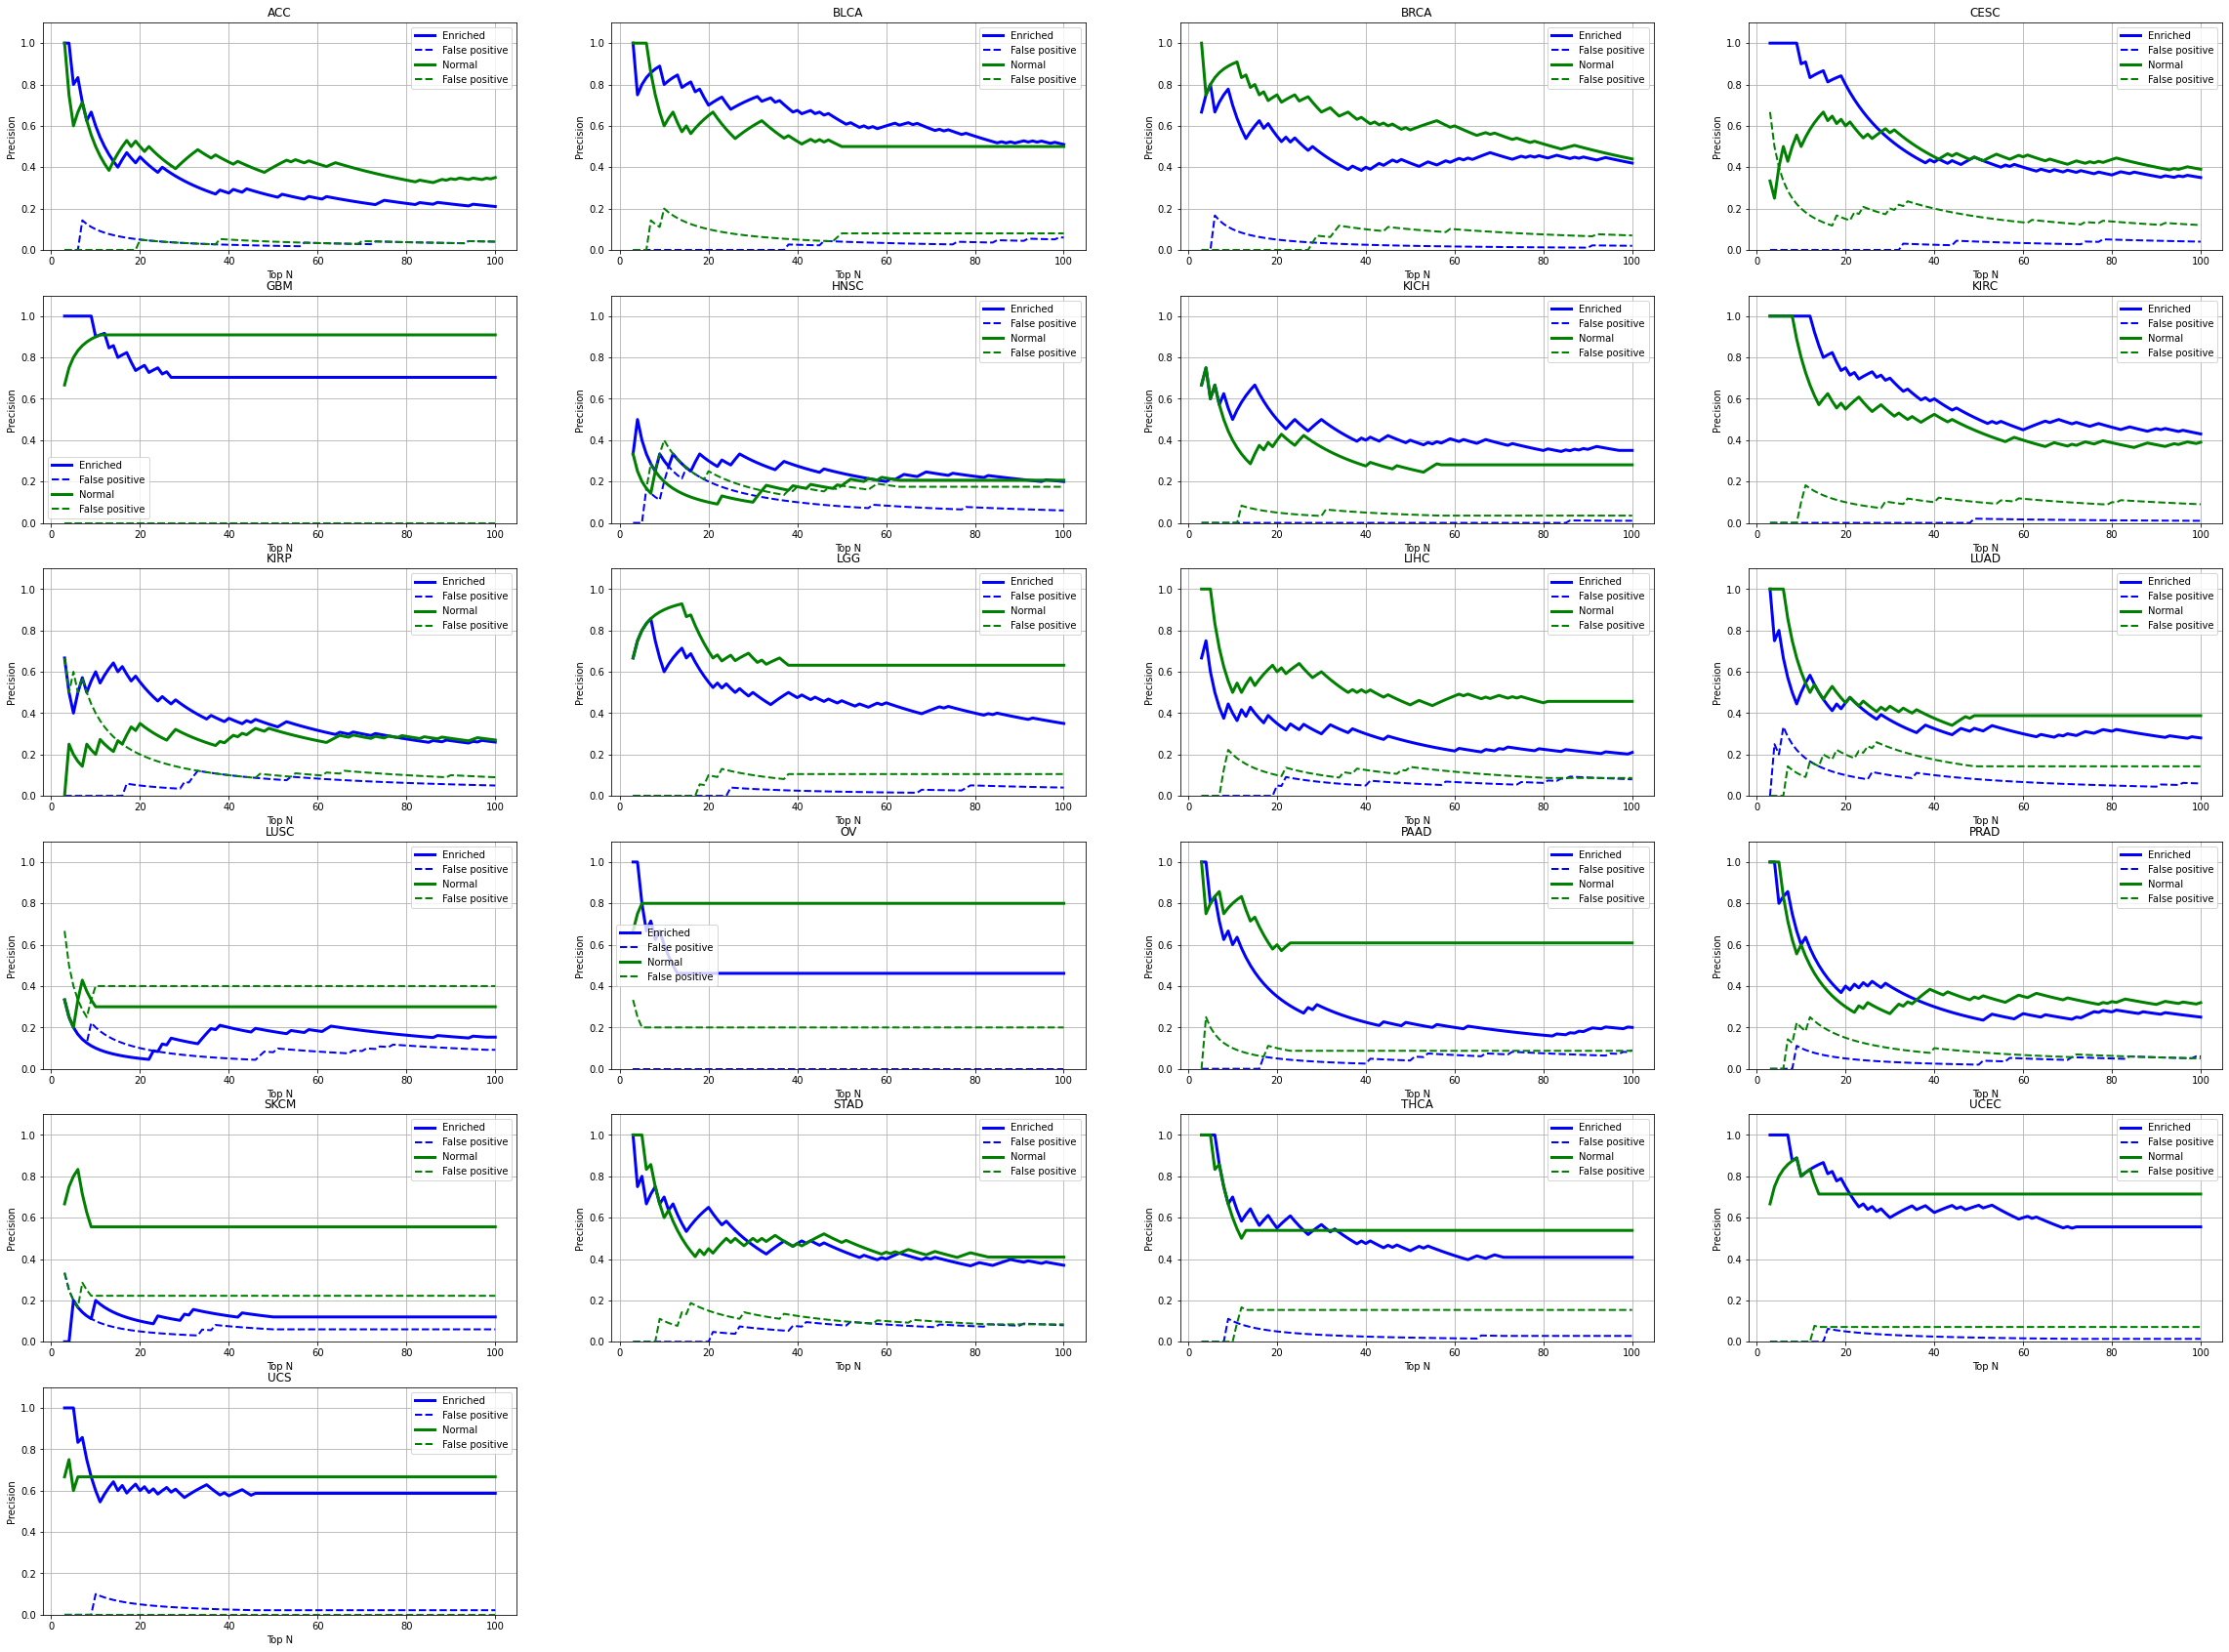

In [ ]:
generate_graph(path_results_notebook_10p, cancer_type_10p)

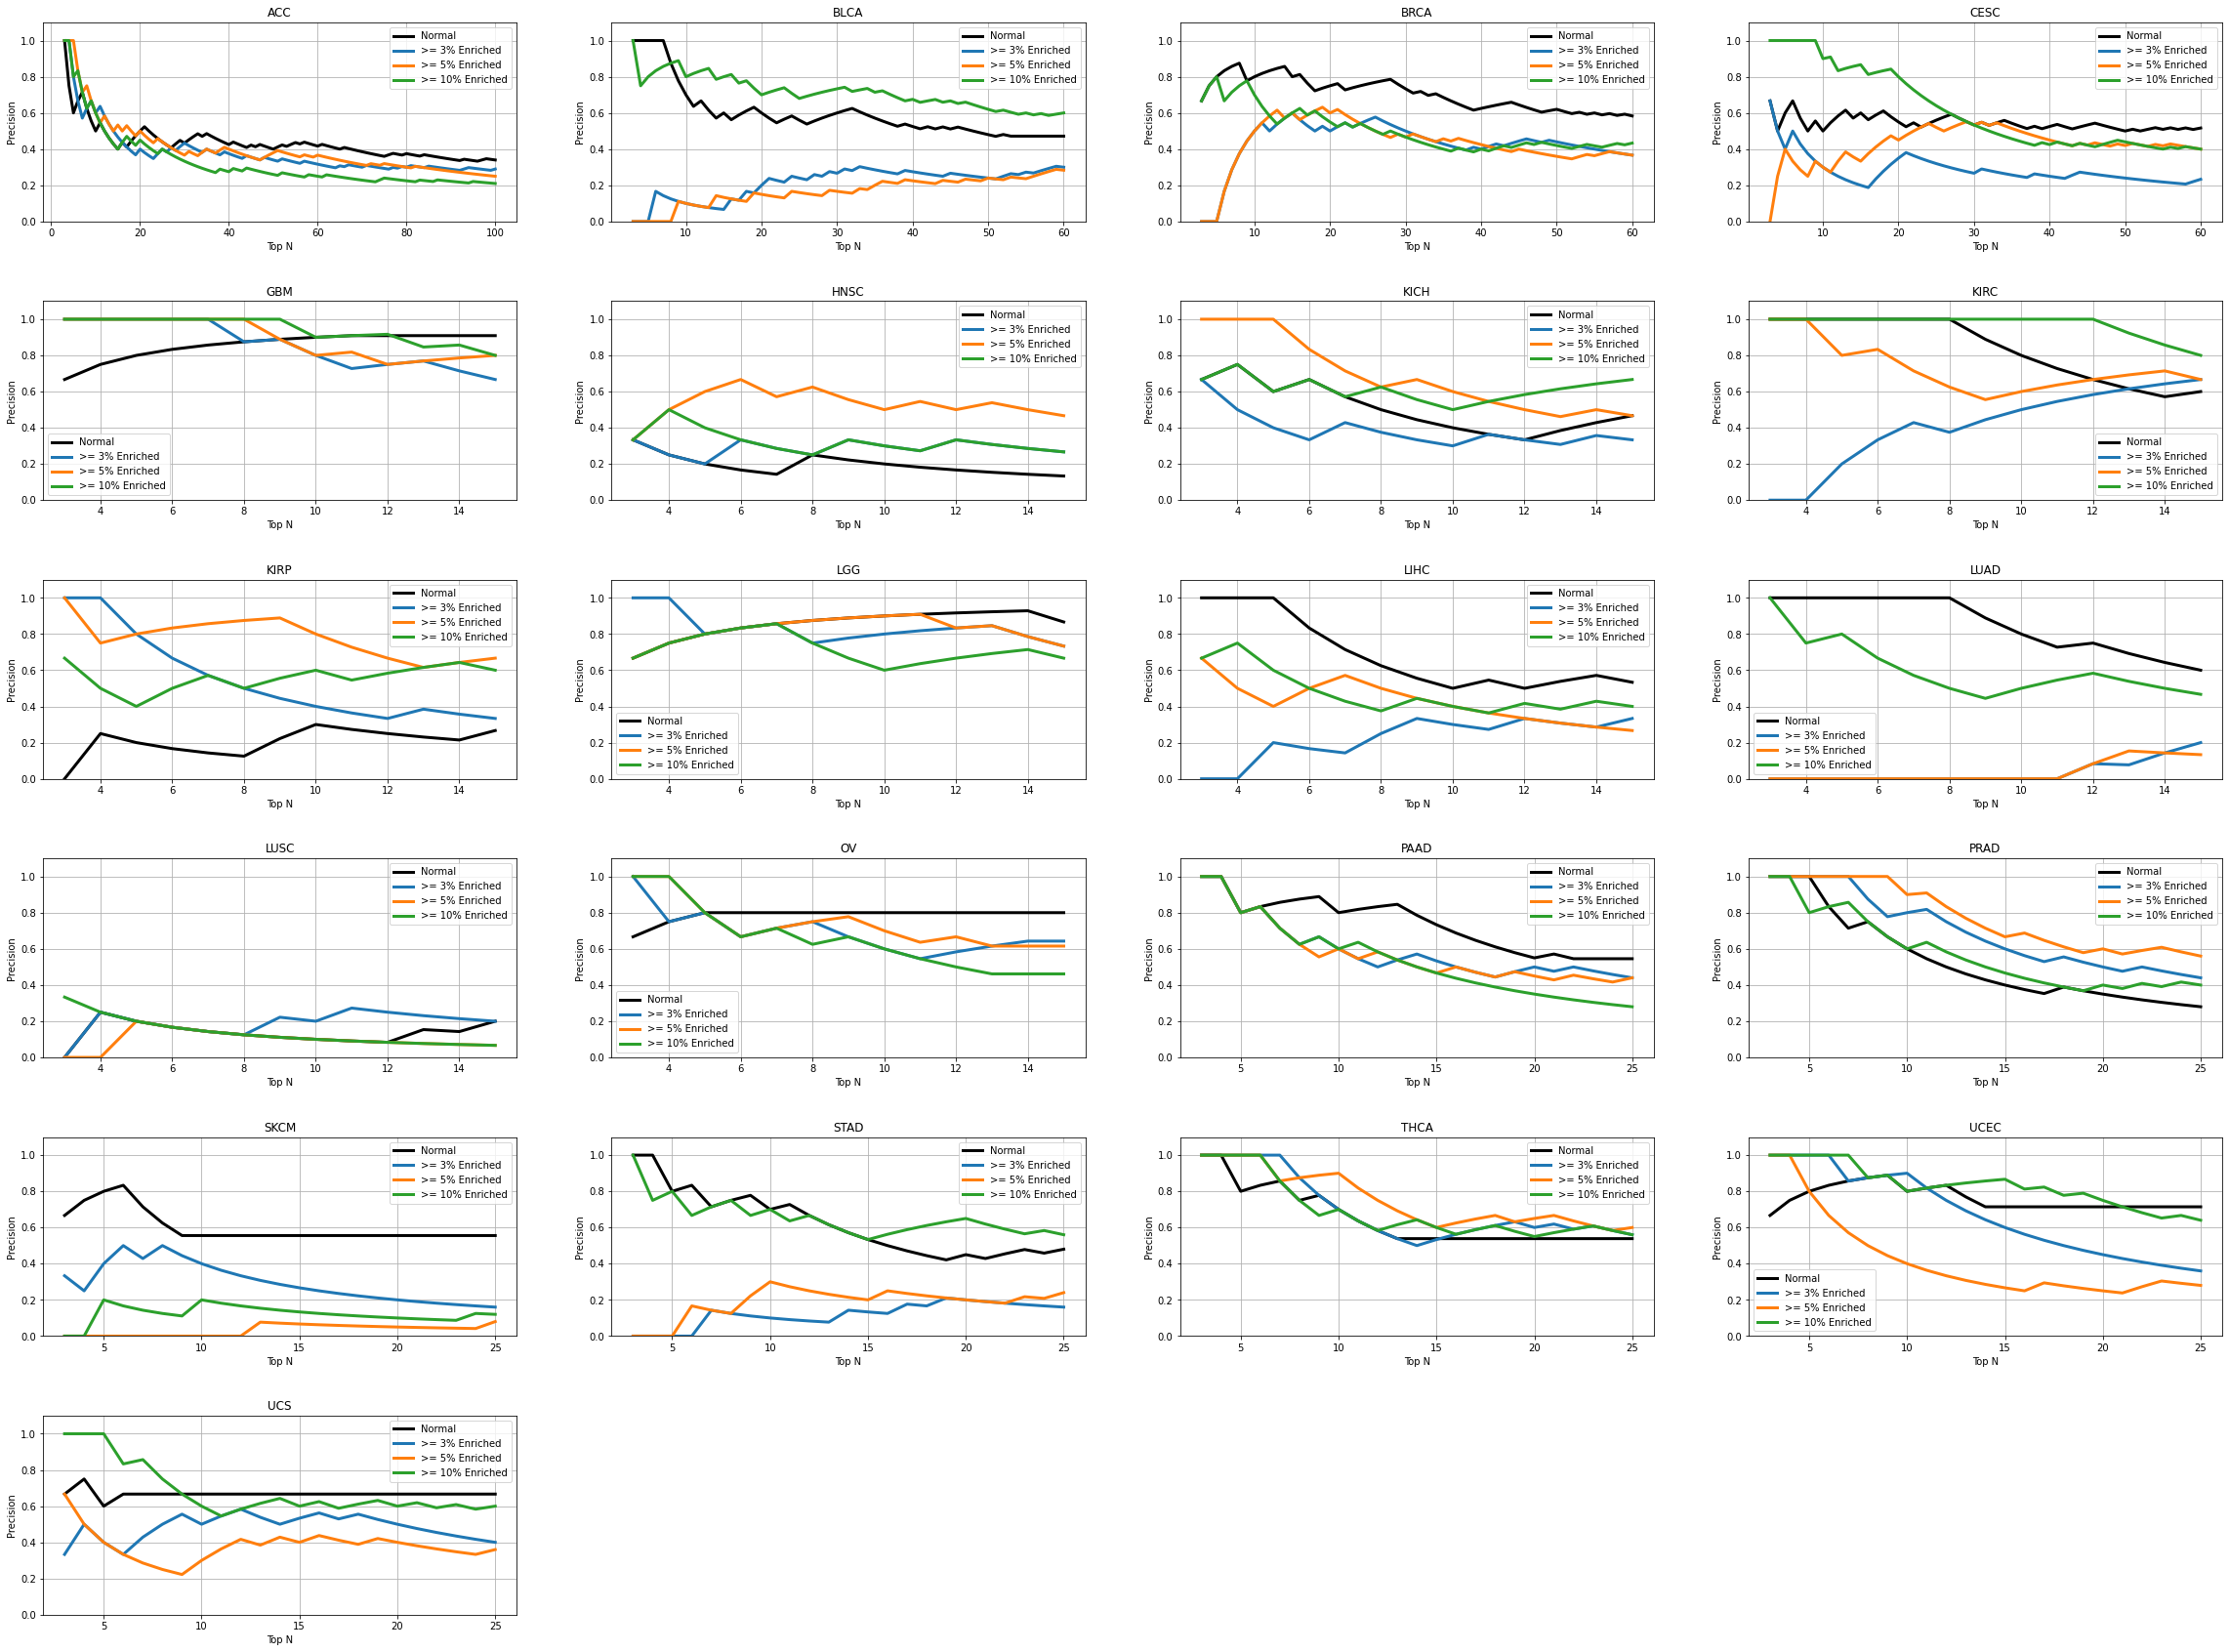

In [ ]:
generate_graph_all(path_results_notebook_3p, path_results_notebook_5p, path_results_notebook_10p, cancer_type_10p)

# IntoGen Analysis

In [ ]:
def generate_graphs_genes_intogen_bkp(all_result_files_intogen, all_result_files, N):
    number_of_columns = 4
    number_of_rows = math.ceil(len(all_result_files)/number_of_columns)
    fig = plt.figure(figsize=(10*number_of_columns, 5*number_of_rows))
    position = 1

    for cancer_type in all_result_files:
        ax = plt.subplot(number_of_rows, number_of_columns, position)
        l_results_intogen = all_result_files_intogen[cancer_type]
        gene_results_intogen = get_gene_list(l_results_intogen[0], sep='\t')
        result_file_name_normal = all_result_files[cancer_type][0] #normal
        gene_results_normal = get_gene_list(result_file_name_normal)

        for result_file_name in all_result_files[cancer_type]:
            
            if result_file_name.split("_")[4].upper() == 'ENRIC':
                gene_results = get_gene_list(result_file_name)
                gene_results_enric_normal_dif = set(gene_results) - set(gene_results_normal) # o que o enric trouxe mais do normal
                gene_found_intogen = gene_results_enric_normal_dif & set(gene_results_intogen) # genes do enric que esta presente no intogen
                # convert in list
                gene_results_enric_normal_dif = list(gene_results_enric_normal_dif)
                gene_found_intogen = list(gene_found_intogen)
                #sample_percent_intogen = get_sample_percent_intogen(l_results_intogen[0], gene_found_intogen)
                
                # plt
                if len(gene_found_intogen)>0:
                    sample_percent_intogen = get_sample_percent_intogen_df(l_results_intogen[0], gene_found_intogen)
                    print(sample_percent_intogen)
                    #ax = plt.subplot(number_of_rows, number_of_columns, position)
                    ax = sample_percent_intogen.plot.bar(x='gene', y='samples', rot=0)
                    #ax.bar(x=sample_percent_intogen['gene'],y=sample_percent_intogen['samples'])
                    
        
        ax.legend()
        ax.set_title(cancer_type)
        ax.set_xlabel('Genes')
        ax.set_ylabel('Samples (%)')
        ax.set_ylim(0.0, 1.1)
        position = position + 1
        #plt.grid(True)
    plt.show()

In [ ]:
def generate_graphs_genes_intogen(all_result_files_maf, all_result_files_intogen, all_result_files, N, number_of_columns = 4):
    #number_of_columns = 4
    number_of_rows = math.ceil(len(all_result_files)/number_of_columns)
    fig = plt.figure(figsize=(10*number_of_columns, 5*number_of_rows))
    position = 1

    for cancer_type in all_result_files:
        
        l_results_intogen = all_result_files_intogen[cancer_type]
        gene_results_intogen = get_gene_list(l_results_intogen[0], sep='\t')
        result_file_name_normal = all_result_files[cancer_type][0] #normal
        gene_results_normal = get_gene_list(result_file_name_normal)

        # genes of the maf
        maf_name = all_result_files_maf[cancer_type][0]
        maf_genes = []
        for i in open(maf_name):
            maf_genes.append(i.replace('\n', ''))
        
        for result_file_name in all_result_files[cancer_type]:
            
            if result_file_name.split("_")[4].upper() == 'ENRIC':
                gene_results = get_gene_list(result_file_name)
                gene_results_enric_normal_dif = set(gene_results) - set(gene_results_normal) # o que o enric trouxe e o normal não trouxe
                
                # alfredo inicio
                gene_results_enric_normal_dif = gene_results_enric_normal_dif & set(maf_genes)   # genes do enric que estão presentes no maf tambm
                """
                print('cancer: ' + cancer_type)
                print('tamanho')
                print(len(set(maf_genes)))
                """
                # alfredo fim
                gene_found_intogen = gene_results_enric_normal_dif & set(gene_results_intogen) # genes do enric que esta presente no intogen
                # convert in list
                gene_results_enric_normal_dif = list(gene_results_enric_normal_dif)
                gene_found_intogen = list(gene_found_intogen)
                sample_percent_intogen = get_sample_percent_intogen(l_results_intogen[0], gene_found_intogen)
                
                # plt
                if len(gene_found_intogen)>0:
                    sample_percent_intogen_df = get_sample_percent_intogen_df(l_results_intogen[0], gene_found_intogen)
                    
                    ax = plt.subplot(number_of_rows, number_of_columns, position)
                    plt.grid(True)
                    ax.set_axisbelow(True)
                    x = list(sample_percent_intogen_df['gene'])
                    y = list(sample_percent_intogen_df['samples'])

                    print(cancer_type)
                    print(x)
                    print(y)
                    ax.bar(x,y)
                    position = position + 1
                    #plt.subplots_adjust(wspace = 2)
                    plt.subplots_adjust(hspace = .4)
                    plt.xticks(rotation=45)

                    #ax.legend()
                    ax.set_title(cancer_type)
                    ax.set_xlabel('Genes')
                    ax.set_ylabel('Samples %')
                    ax.set_ylim(0.0, max(y)+1)
                    #plt.legend(loc=2, fontsize = 'x-small')
                    
    fig.tight_layout()
    plt.show()


In [ ]:
def generate_graph_intogen(path_mafs_list, path_intogen, path_results, cancer_type, number_of_columns=4):
    N = 100

    all_result_files = {}
    all_result_files_intogen = {}
    all_result_files_maf = {}
    for can in cancer_type:
        l_results = file_list_in_dir_tpcan(path_results, can)
        l_results_intogen = file_list_in_dir_tpcan(path_intogen, can)
        l_results_mafs = file_list_in_dir_tpcan(path_mafs_list, can)
        
        all_results_cancer_type = []
        all_results_cancer_type_intogen = []
        all_results_cancer_type_maf = []
        all_results_cancer_type.append(path_results+sorted(l_results)[1]) # normal
        all_results_cancer_type.append(path_results+sorted(l_results)[0]) # enric
        all_results_cancer_type_intogen.append(path_intogen+sorted(l_results_intogen)[0]) # enric
        all_results_cancer_type_maf.append(path_mafs_list+sorted(l_results_mafs)[0]) # enric
        
        
        all_result_files[can.upper()] = all_results_cancer_type
        all_result_files_intogen[can.upper()] = all_results_cancer_type_intogen
        all_result_files_maf[can.upper()] = all_results_cancer_type_maf
        
    generate_graphs_genes_intogen(all_result_files_maf, all_result_files_intogen, all_result_files, N, number_of_columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BLCA
['PIK3CA', 'ERBB2', 'ERBB3', 'RHOA', 'HRAS', 'KRAS', 'CDH1', 'RAF1']
[19.95, 11.92, 9.98, 4.62, 4.14, 3.89, 3.16, 0.97]
BRCA
['CTCF', 'CREBBP', 'FGFR2', 'SMAD4']
[2.16, 1.44, 1.23, 0.51]
CESC
['BAP1', 'LATS1', 'COL1A1', 'TGFBR2']
[3.13, 3.13, 2.08, 1.74]
GBM
['PTPN11', 'NRAS']
[2.81, 1.02]
HNSC
['CASP8', 'CREBBP', 'SMAD4', 'RAC1', 'PTEN', 'RHOA']
[9.76, 6.37, 2.59, 2.59, 1.99, 1.99]
KIRC
['RANBP2', 'MAX']
[2.23, 1.12]
KIRP
['NUP214', 'KRAS']
[2.9, 1.81]
LGG
['NOTCH1', 'KIT', 'MTOR', 'PLCG1', 'NRAS']
[6.48, 1.18, 0.98, 0.79, 0.79]
LIHC
['RPS6KA3', 'TSC2', 'PIK3CA', 'NFE2L2', 'KRAS', 'CACNA1D', 'NRAS']
[3.89, 3.33, 3.33, 2.78, 1.39, 1.39, 1.11]
LUAD
['KDR', 'PIK3CA', 'NRAS']
[6.43, 4.46, 0.54]
LUSC
['PIK3CA', 'NF1', 'HRAS']
[11.68, 9.98, 1.49]
PAAD
['TGFBR2', 'PIK3CA']
[3.98, 2.84]
PCPG
['RANBP2']
[1.12]
PRAD
['LRP1B', 'KDM6A']
[5.08, 1.22]
SKCM
['TP53', 'RAC1', 'PBRM1', 'HRAS']
[8.8, 4.29, 4.08, 1.07]
STAD
['KRAS', 'CDH11', 'ERBB3', 'RHOA', 'PTEN', 'ERBB2']
[5.73, 5.5, 4.82, 4.82, 

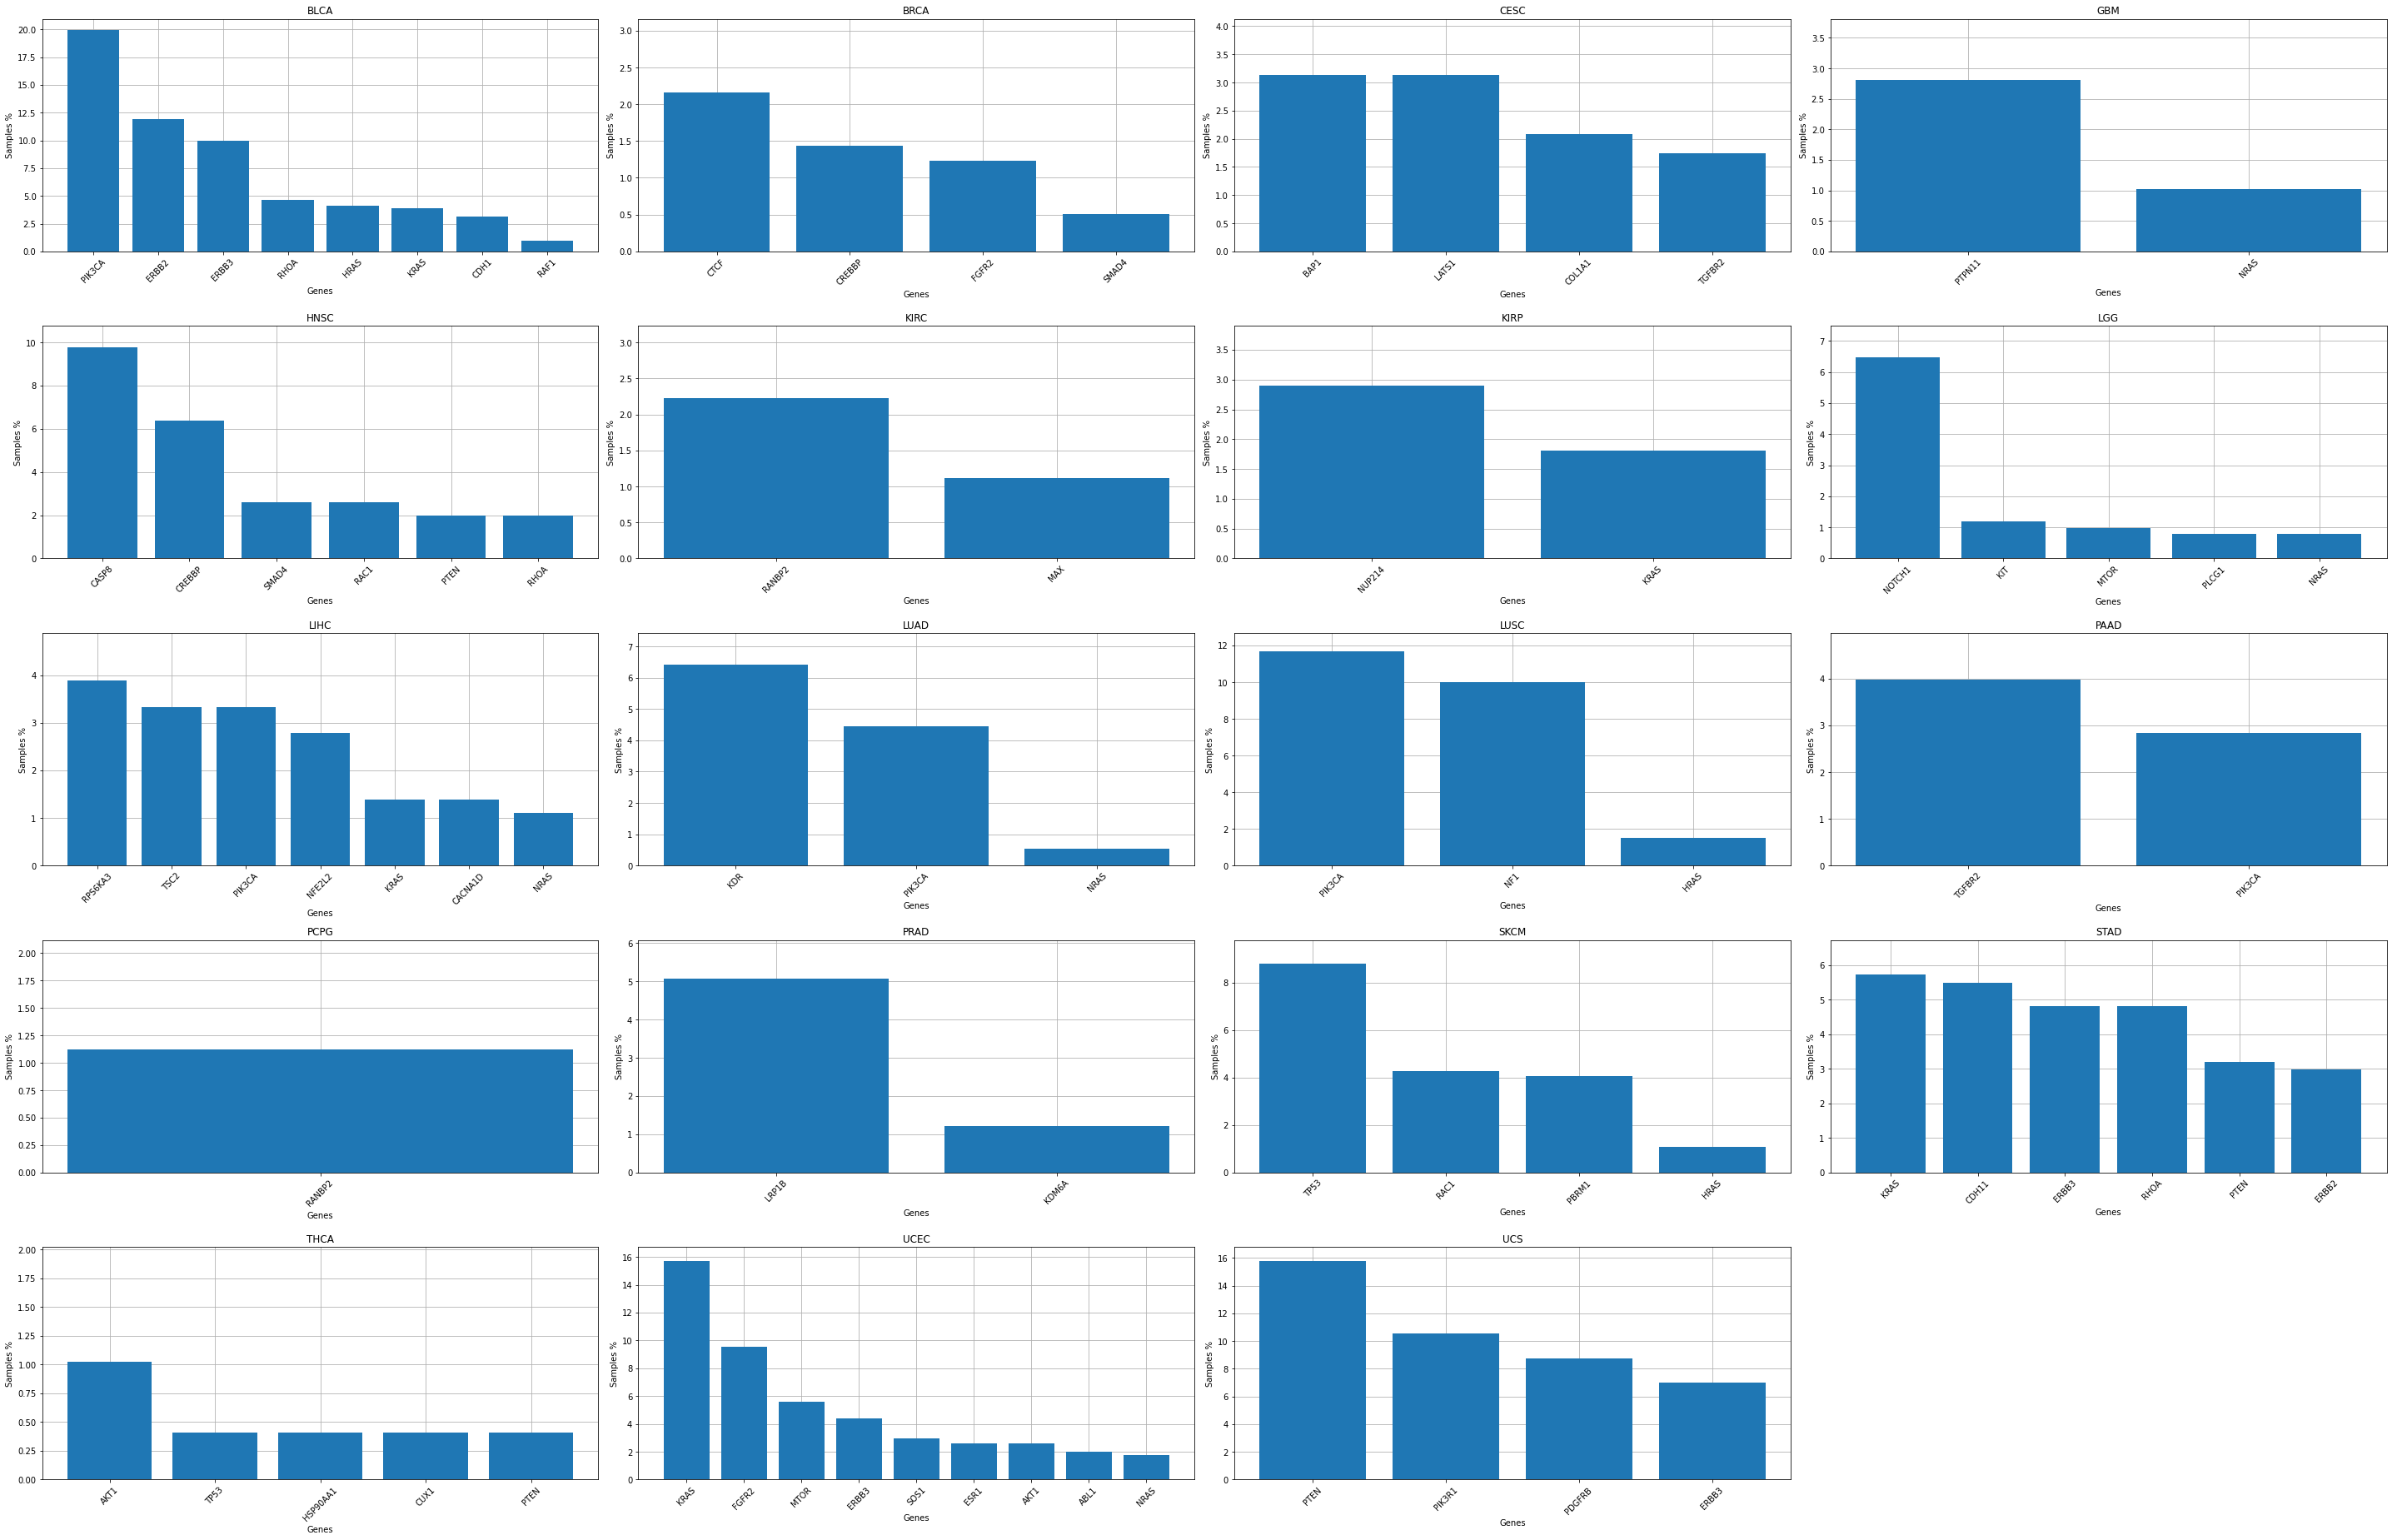

In [ ]:
generate_graph_intogen(path_mafs_list, path_intogen, path_results_notebook_3p, cancer_type_3p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BLCA
['PIK3CA', 'ERBB2', 'ERBB3', 'TSC1', 'RXRA', 'RHOA', 'HRAS', 'KRAS', 'RAF1']
[19.95, 11.92, 9.98, 6.33, 6.08, 4.62, 4.14, 3.89, 0.97]
CESC
['NOTCH1', 'BAP1', 'LATS1', 'HLA-B', 'HLA-A', 'B2M']
[5.9, 3.13, 3.13, 2.78, 1.74, 1.39]
GBM
['PTPN11', 'NRAS']
[2.81, 1.02]
HNSC
['CASP8', 'NFE2L2', 'NCOR1', 'SMAD4', 'RAC1', 'PTEN', 'RHOA']
[9.76, 5.58, 2.79, 2.59, 2.59, 1.99, 1.99]
KICH
['TSC2']
[3.08]
KIRC
['RANBP2', 'MAX']
[2.23, 1.12]
KIRP
['NUP214', 'KRAS']
[2.9, 1.81]
LGG
['NOTCH1', 'KIT', 'MTOR', 'PLCG1', 'NRAS', 'CDKN2C']
[6.48, 1.18, 0.98, 0.79, 0.79, 0.59]
LIHC
['RPS6KA3', 'TSC2', 'PIK3CA', 'NFE2L2', 'KRAS', 'NRAS']
[3.89, 3.33, 3.33, 2.78, 1.39, 1.11]
LUAD
['KDR', 'PIK3CA', 'MAP2K1']
[6.43, 4.46, 1.43]
LUSC
['PIK3CA', 'FN1', 'HRAS']
[11.68, 6.58, 1.49]
PAAD
['GNAS', 'PIK3CA', 'IRS4']
[4.55, 2.84, 1.14]
PRAD
['LRP1B']
[5.08]
SKCM
['RAC1']
[4.29]
STAD
['CDH11', 'ERBB3', 'RHOA', 'ERBB2']
[5.5, 4.82, 4.82, 2.98]
THCA
['AKT1', 'HSP90AA1', 'PTEN']
[1.02, 0.41, 0.41]
UCEC
['KRAS', 'FGFR2'

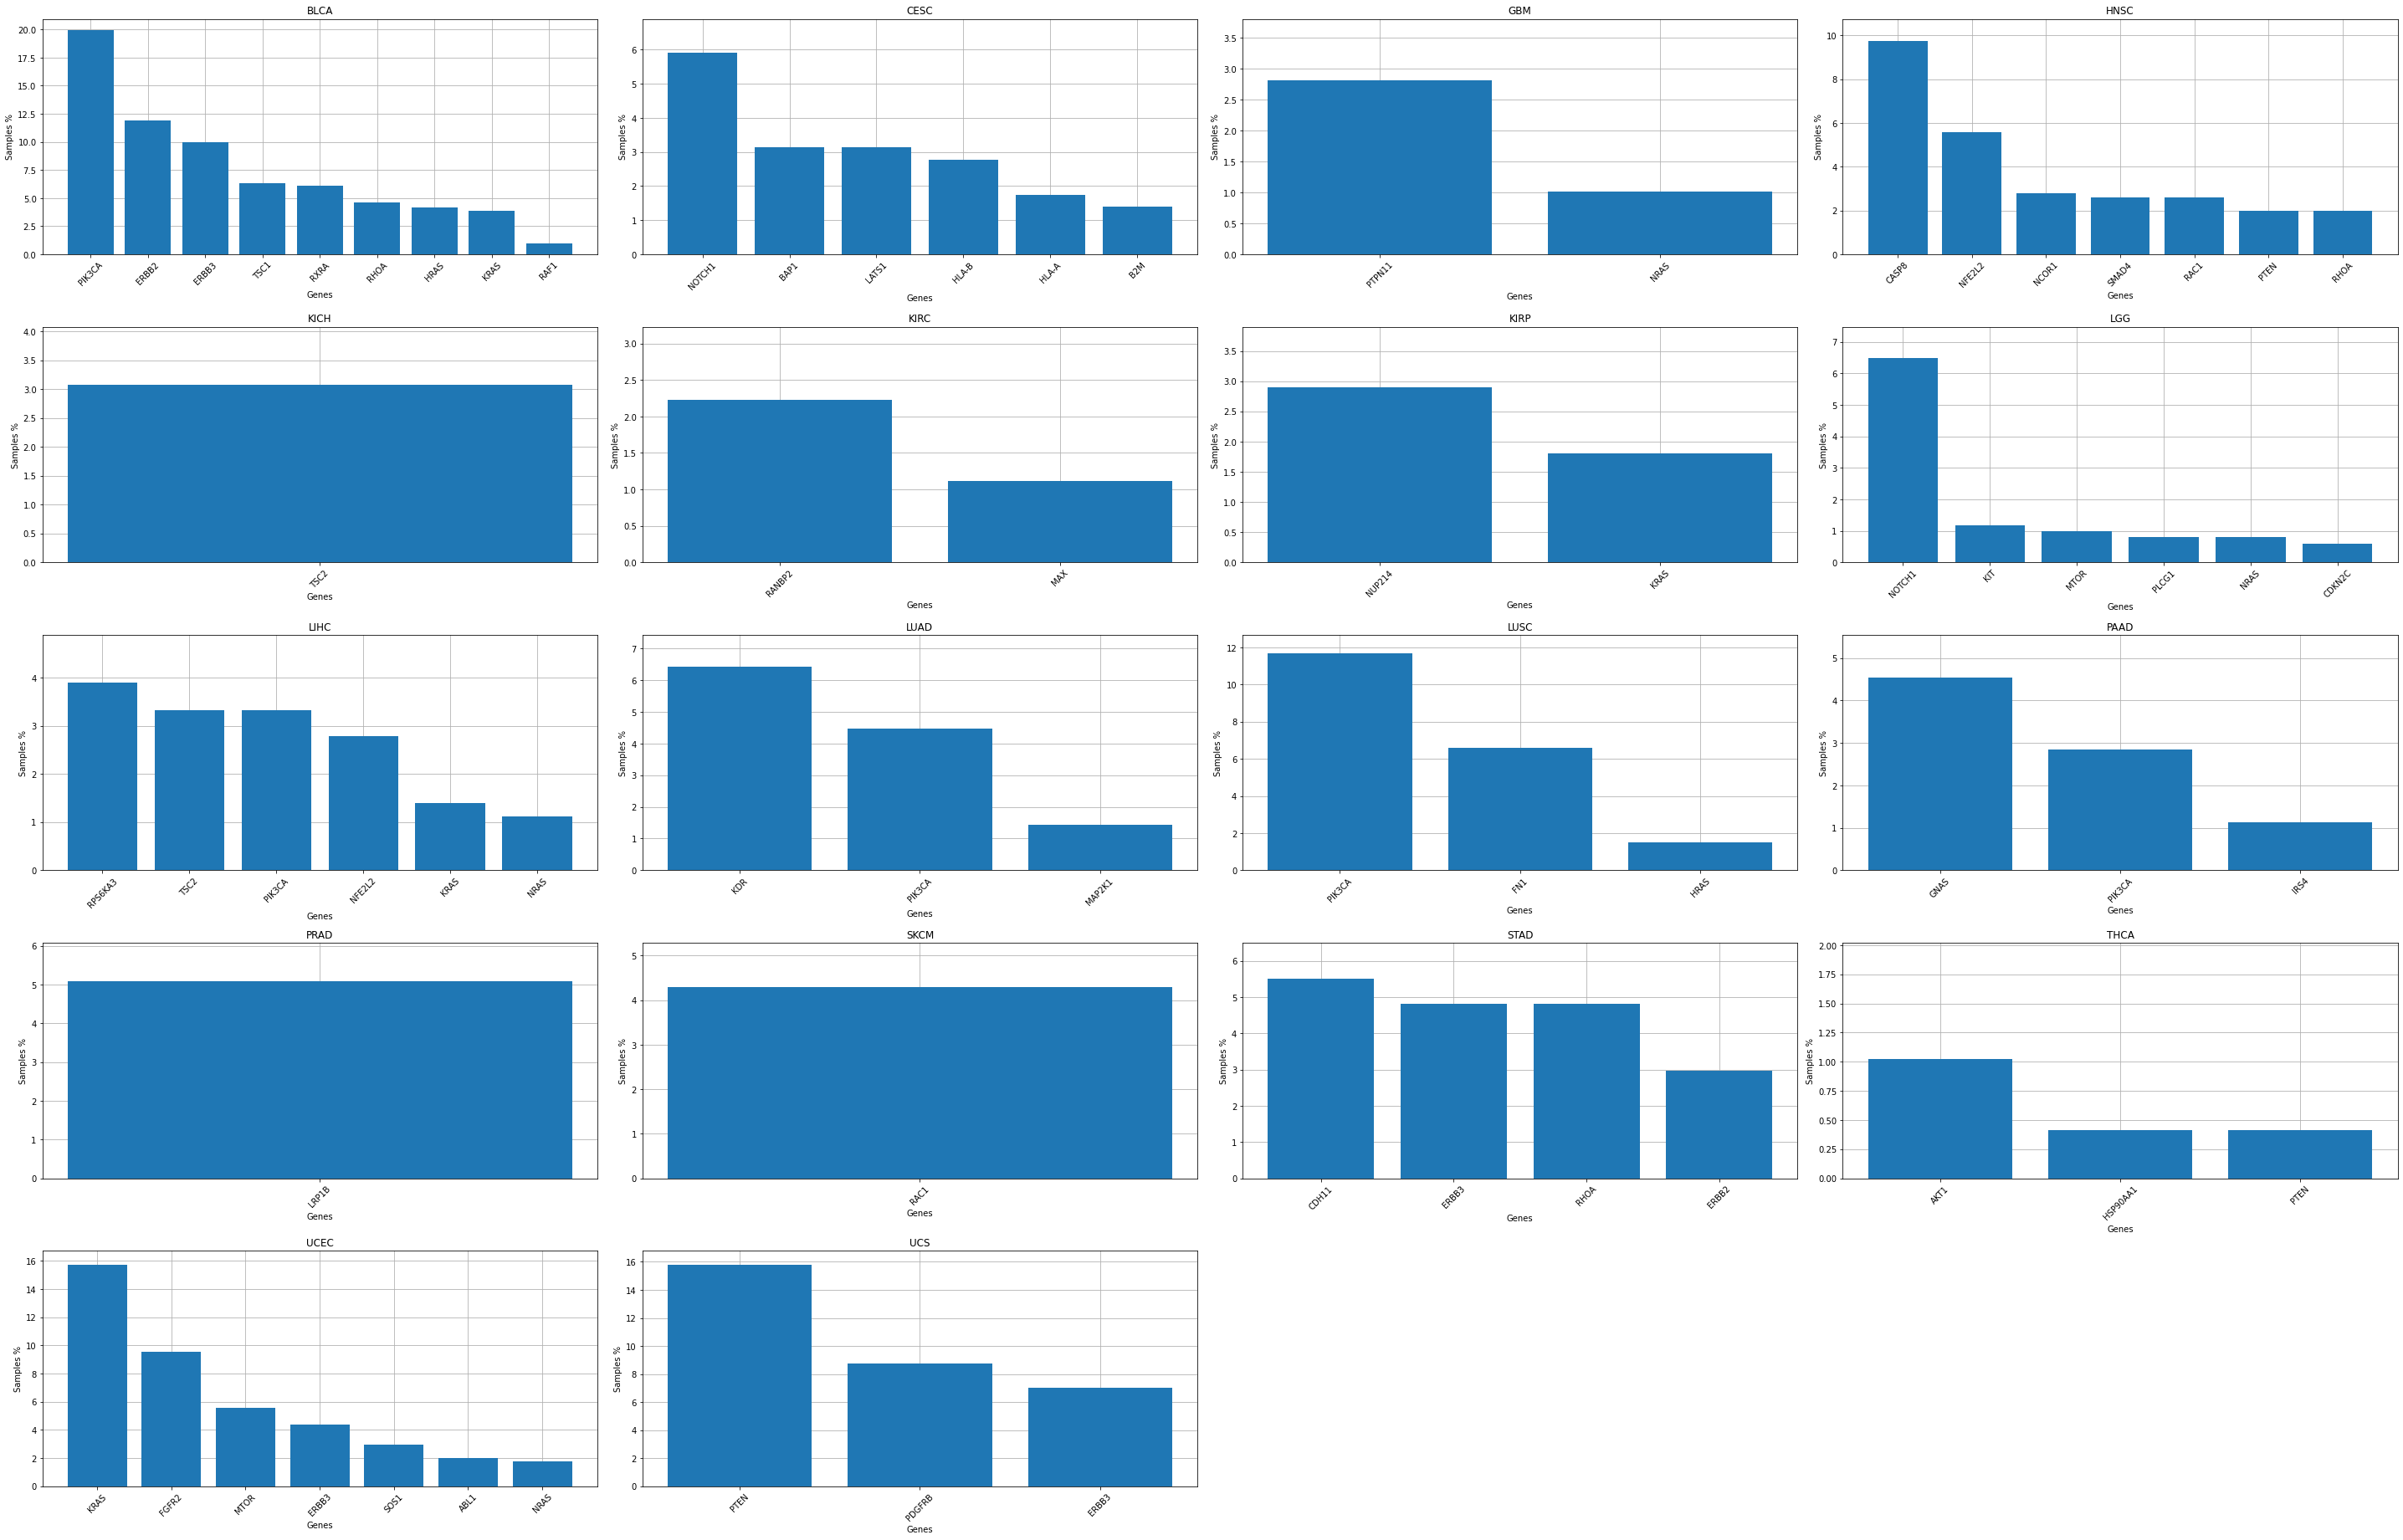

In [ ]:
generate_graph_intogen(path_mafs_list, path_intogen, path_results_notebook_5p, cancer_type_5p)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BLCA
['PIK3CA', 'ERBB2', 'ERBB3', 'TSC1', 'RHOA', 'HRAS', 'KRAS', 'PTEN', 'PIK3CB', 'RAF1']
[19.95, 11.92, 9.98, 6.33, 4.62, 4.14, 3.89, 3.16, 2.19, 0.97]
BRCA
['RB1', 'CTCF', 'CREBBP', 'FBXW7', 'SMAD4']
[2.26, 2.16, 1.44, 1.34, 0.51]
CESC
['LATS1']
[3.13]
GBM
['PTPN11', 'NRAS']
[2.81, 1.02]
HNSC
['NOTCH1', 'CASP8', 'CREBBP', 'FBXW7', 'NFE2L2', 'MYH9', 'RAC1', 'RHOA']
[16.53, 9.76, 6.37, 6.37, 5.58, 4.58, 2.59, 1.99]
KIRC
['MAX']
[1.12]
KIRP
['NUP214', 'KRAS', 'DNMT3A']
[2.9, 1.81, 1.45]
LGG
['NOTCH1', 'KIT', 'MTOR', 'PLCG1', 'NRAS']
[6.48, 1.18, 0.98, 0.79, 0.79]
LIHC
['RPS6KA3', 'PIK3CA', 'GNAS', 'KRAS', 'NRAS']
[3.89, 3.33, 2.22, 1.39, 1.11]
LUAD
['KDR']
[6.43]
LUSC
['PIK3CA', 'FN1']
[11.68, 6.58]
PAAD
['GNAS', 'TGFBR2', 'PIK3CA', 'U2AF1']
[4.55, 3.98, 2.84, 1.14]
PRAD
['LRP1B', 'KDM6A']
[5.08, 1.22]
STAD
['KRAS', 'PTEN', 'ERBB2', 'SDC4']
[5.73, 3.21, 2.98, 0.92]
THCA
['AKT1', 'TP53', 'HSP90AA1', 'CUX1', 'PTEN']
[1.02, 0.41, 0.41, 0.41, 0.41]
UCEC
['KRAS', 'PPP2R1A', 'FGFR2', 'MTOR'

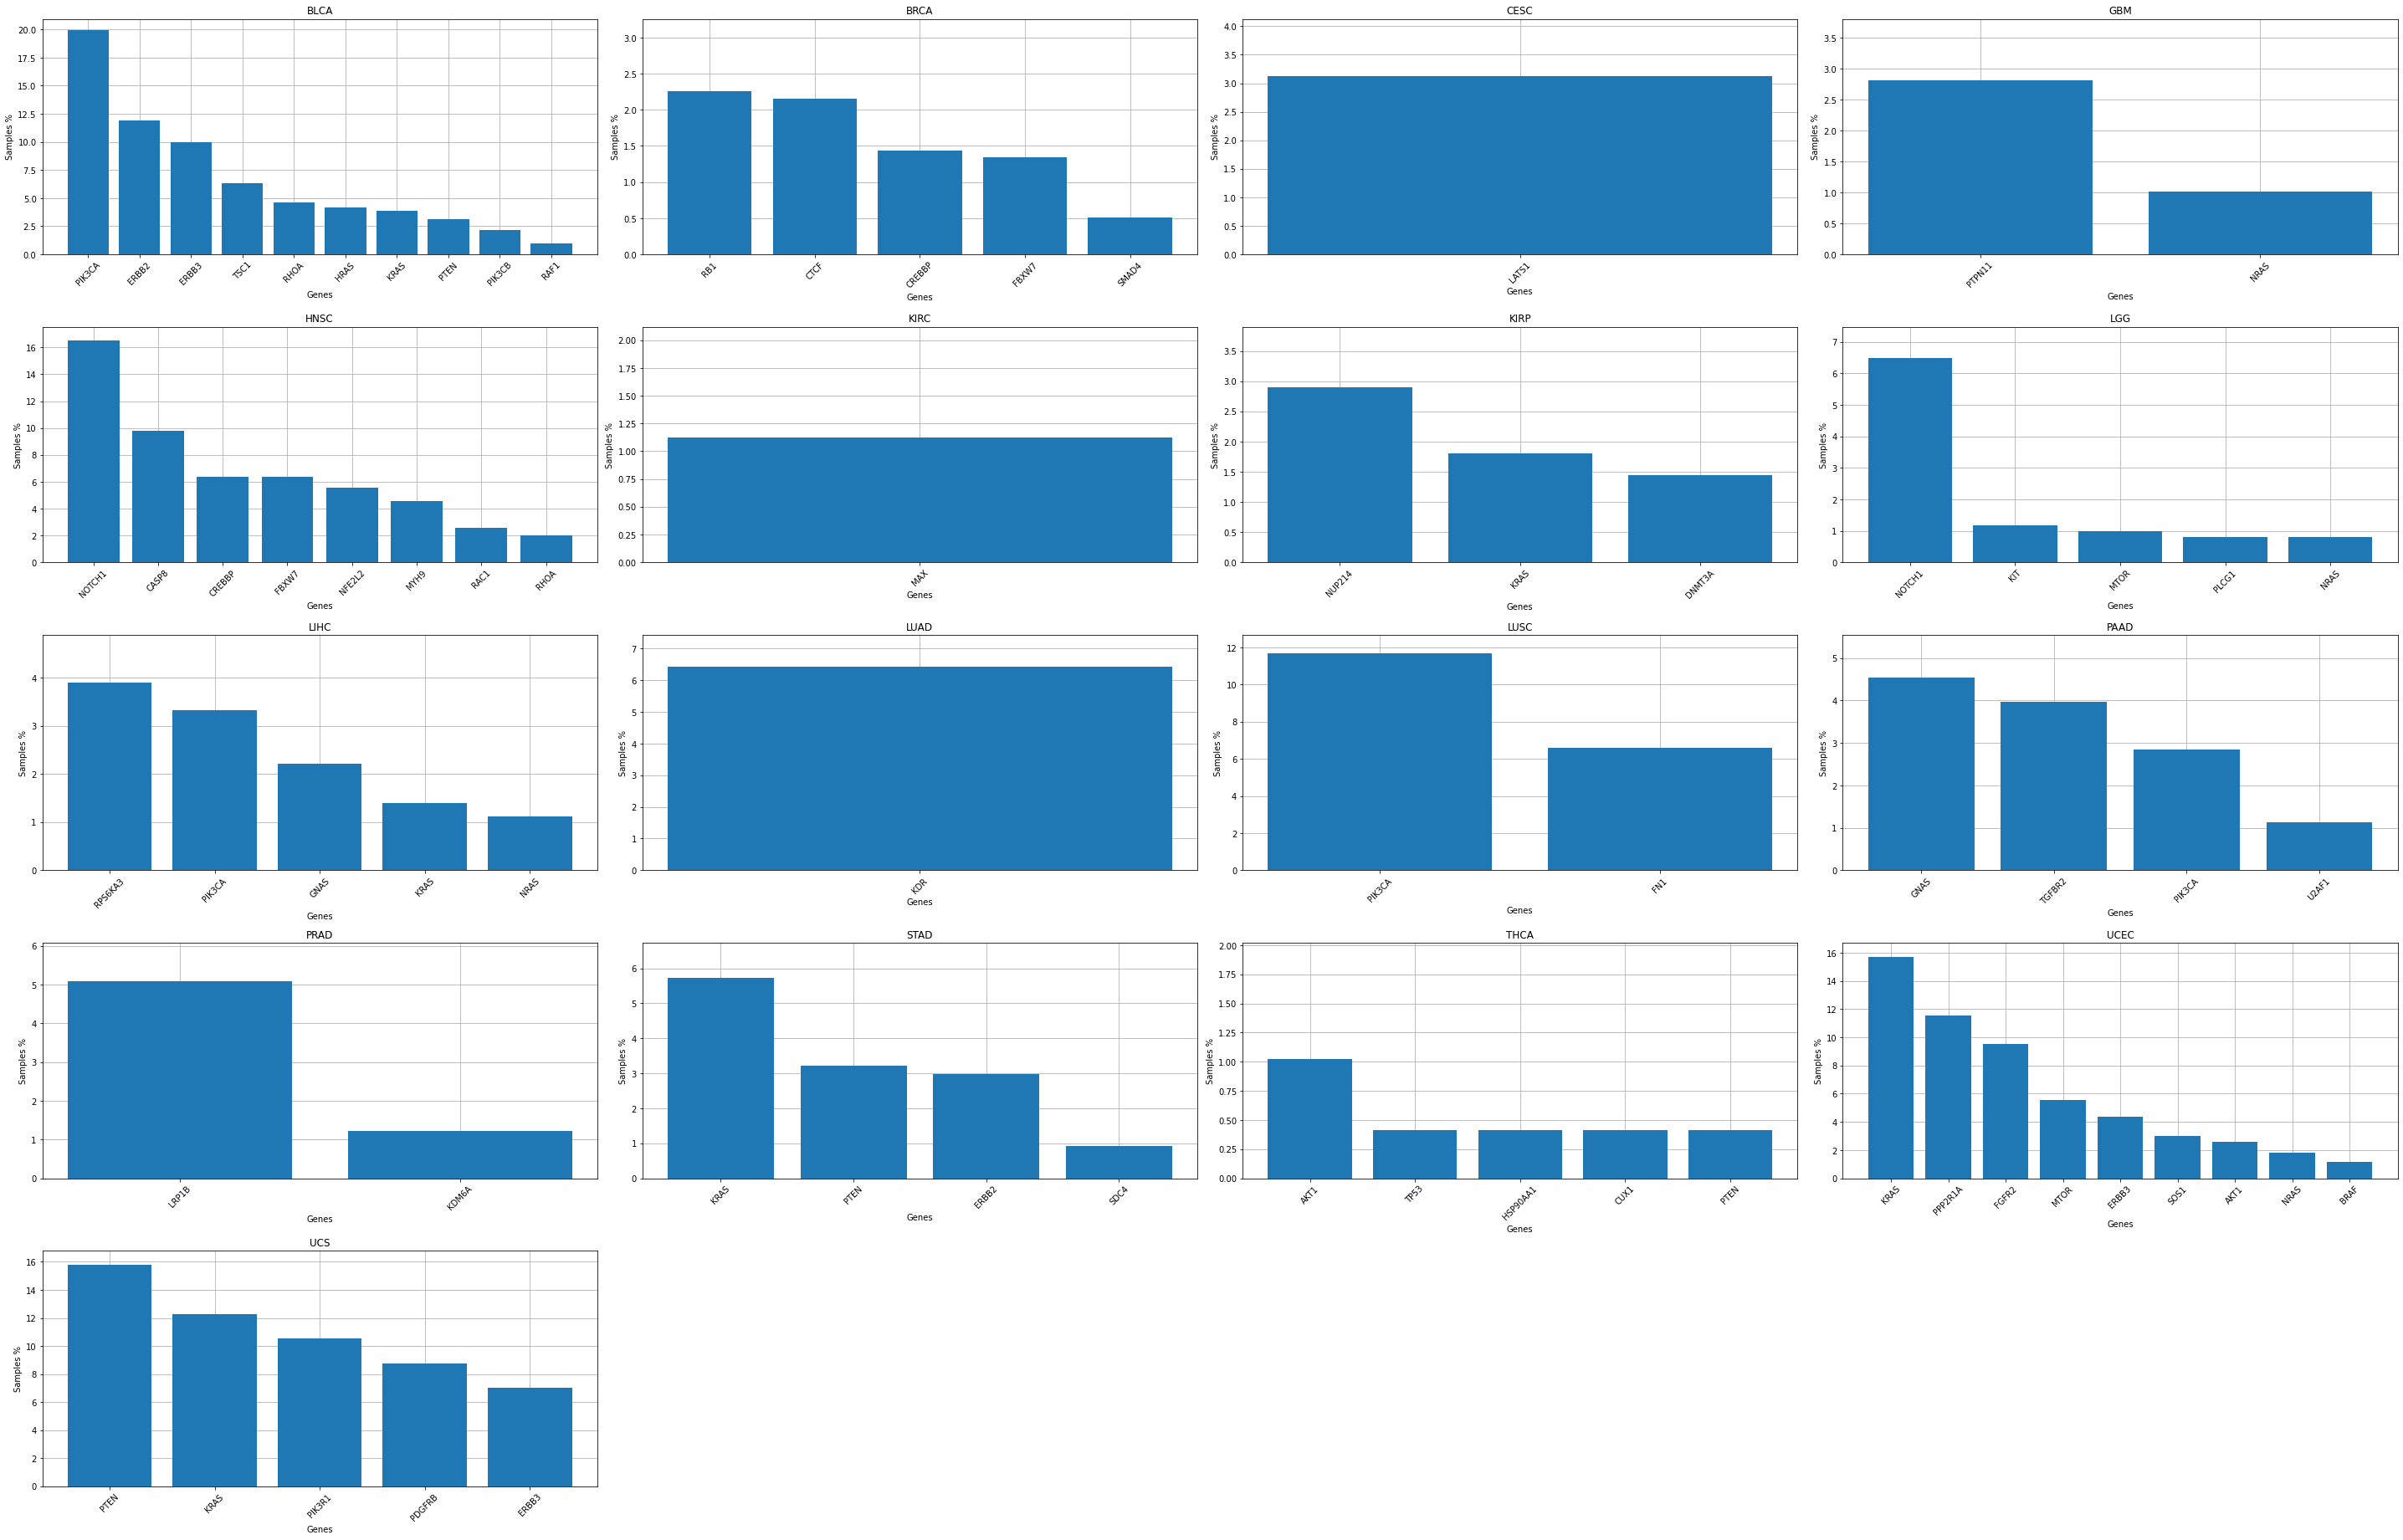

In [ ]:
generate_graph_intogen(path_mafs_list, path_intogen, path_results_notebook_10p, cancer_type_10p)

In [ ]:
maf = ['ab', 'ax', 'az', 'am']
enric = ['ab', 'ac', 'ad']
lista3 = set(enric) - set(maf)
print(lista3)
print(len(lista3))
print(maf)
print(enric)

{'ad', 'ac'}
2
['ab', 'ax', 'az', 'am']
['ab', 'ac', 'ad']


# Paper

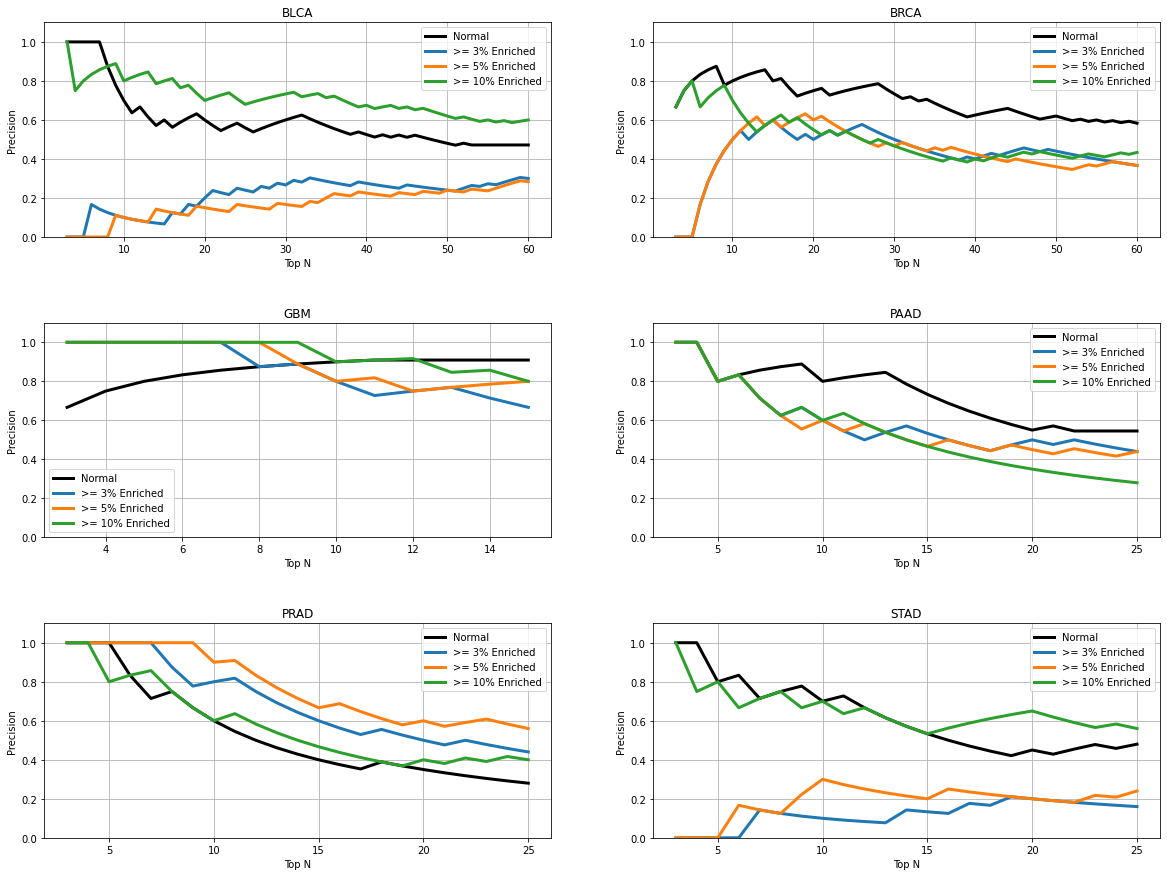

In [ ]:
generate_graph_all(path_results_notebook_3p, path_results_notebook_5p, path_results_notebook_10p, cancer_type_10p_paper, number_of_columns=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


BLCA
['PIK3CA', 'ERBB2', 'ERBB3', 'TSC1', 'RHOA', 'HRAS', 'KRAS', 'PTEN', 'PIK3CB', 'RAF1']
[19.95, 11.92, 9.98, 6.33, 4.62, 4.14, 3.89, 3.16, 2.19, 0.97]
BRCA
['RB1', 'CTCF', 'CREBBP', 'FBXW7', 'SMAD4']
[2.26, 2.16, 1.44, 1.34, 0.51]
GBM
['PTPN11', 'NRAS']
[2.81, 1.02]
PAAD
['GNAS', 'TGFBR2', 'PIK3CA', 'U2AF1']
[4.55, 3.98, 2.84, 1.14]
PRAD
['LRP1B', 'KDM6A']
[5.08, 1.22]
STAD
['KRAS', 'PTEN', 'ERBB2', 'SDC4']
[5.73, 3.21, 2.98, 0.92]


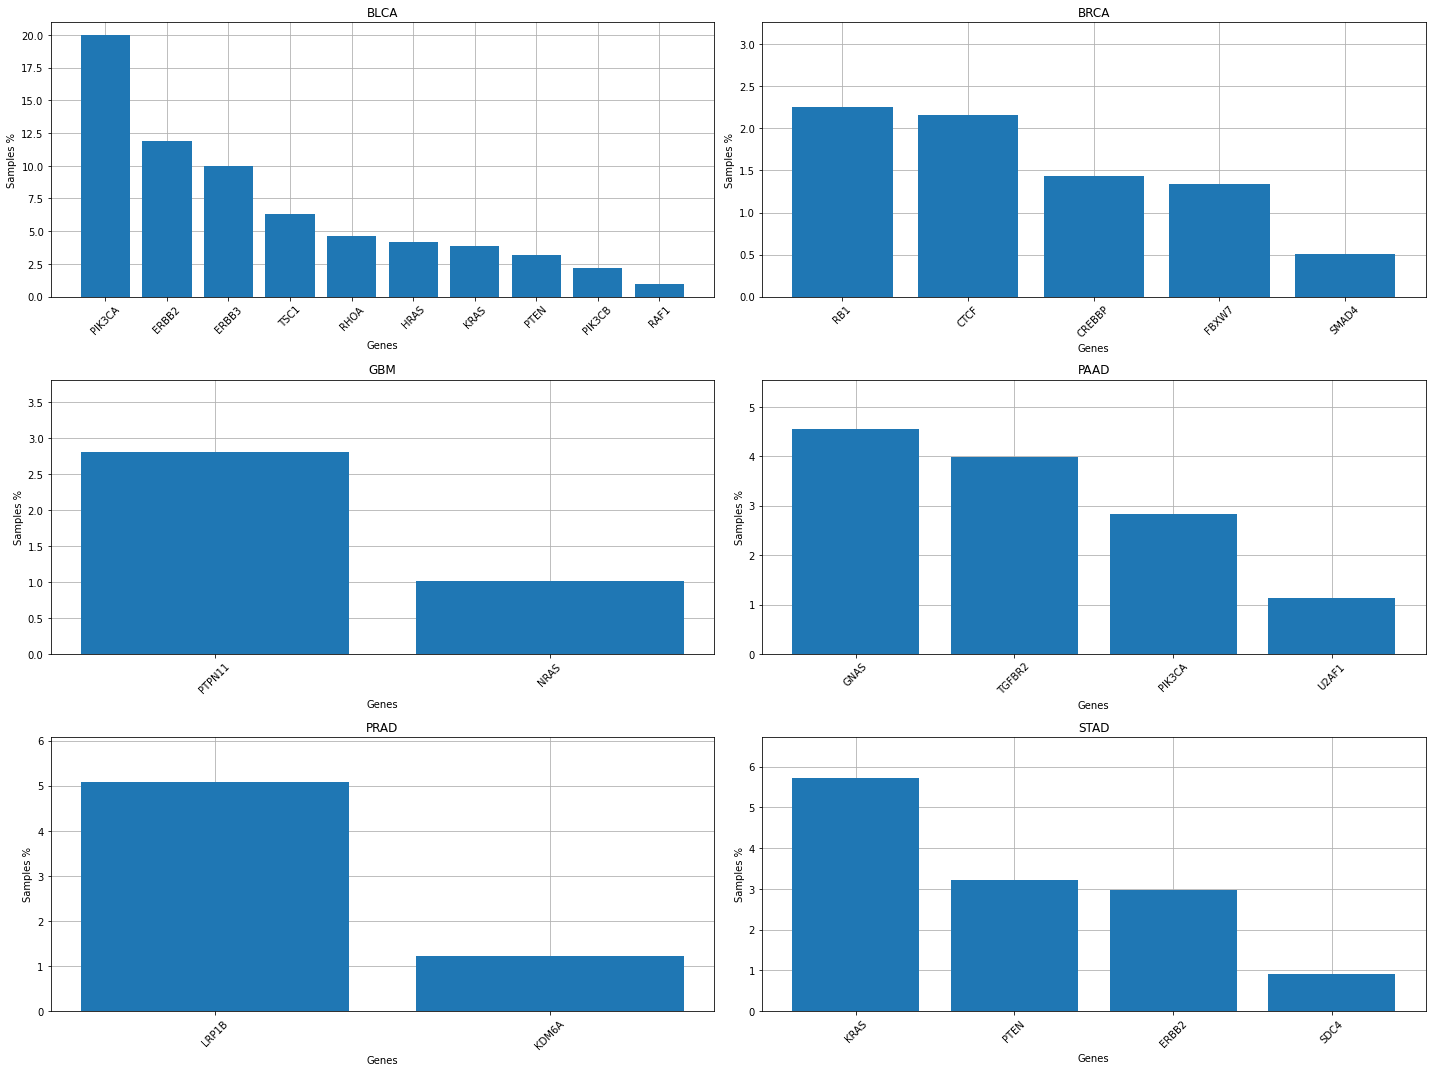

In [ ]:
generate_graph_intogen(path_mafs_list, path_intogen, path_results_notebook_10p, cancer_type_10p_paper, number_of_columns=2)

In [ ]:
#plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.fontsize'] = 16

In [ ]:
#plt.rcParams['font.size'] = 12
plt.rcParams['font.size'] = 18

#matplotlib.rcParams.update({'font.size': 22})